# I-94 Traffic Volume Analysis & Predictions

# Author
[Paul Schulken](https://github.com/pschulk/)

# Project Overview

This project is intended to provide the Minnesota Department of Transportation (MNDOT) with information and recommendations about what factors lead to heavy traffic volume and if anything can be done along I-94 to mitigate these factors.

My analysis determined that percent cloud cover was the most important factor in terms of predicting traffic volume. I found that for every one percent increase in cloud cover, the traffic volume increased by 380 vehicles. This may not sound like much but if heavy clouds or a storm rolls in and increases cloud cover by 25%, there will be a corresponding increase of 9500 vehicles. Lastly, after incorporating holidays, I saw that the Minnesota State Fair is the only holiday that produces above average traffic volume. This isn't too surprising since the Minnesota State Fair is the largest fair in the country in terms of daily attendance.

# Data Overview

The [dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#) used for analysis contained hourly I-94 Westbound traffic volume as well as hourly weather data and the presence of holidays. There were just over 48,000 entries ranging from October 2012 to September 2018. The traffic volume was sourced from Minnesota DOT Automatic Traffic Recorder Station #301. The weather data was provided by [OpenWeatherMap](https://openweathermap.org/). The dataset did NOT include whether or not an accident had occured during the hour and it required some modification to get a completely sequential time series.

In [1]:
# Import tools and libraries
import pandas as pd
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1)

from prophet import Prophet
from prophet.utilities import regressor_coefficients

# try:
    # %load_ext autotime
# except:
    # !pip install ipython-autotime
    # %load_ext autotime
    
# %load_ext autotime

In [2]:
# Read in traffic and weather data
df = pd.read_csv('data\Metro_Interstate_Traffic_Volume.csv')
df_noaa = pd.read_csv('data/noaa_data.csv')

In [3]:
# Previewing data
df

holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
0        None  288.28      0.0      0.0          40        Clouds   
1        None  289.36      0.0      0.0          75        Clouds   
2        None  289.58      0.0      0.0          90        Clouds   
3        None  290.13      0.0      0.0          90        Clouds   
4        None  291.14      0.0      0.0          75        Clouds   
...       ...     ...      ...      ...         ...           ...   
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0          90  Thunderstorm   
48202    None  282.09      0.0      0.0          90        Clouds   
48203    None  282.12      0.0      0.0          90        Clouds   

          weather_description            date_time  traffic_volume  
0            scattered clouds  2012-10-02 09:00:00            5545  
1               broken clouds  2012-10-02 10:00:00            4516  
2             overcast clouds  2012-10-02 11:00:00            4767  
3             overcast clouds  2012-10-02 12:00:00            5026  
4               broken clouds  2012-10-02 13:00:00            4918  
...                       ...                  ...             ...  
48199           broken clouds  2018-09-30 19:00:00            3543  
48200         overcast clouds  2018-09-30 20:00:00            2781  
48201  proximity thunderstorm  2018-09-30 21:00:00            2159  
48202         overcast clouds  2018-09-30 22:00:00            1450  
48203         overcast clouds  2018-09-30 23:00:00             954  

[48204 rows x 9 columns]

Per the UCI website that hosts the data, the feature descriptions are as follows:

holiday: Categorical US National holidays plus regional holiday, Minnesota State Fair<br>
temp: Numeric Average temp in kelvin<br>
rain_1h: Numeric Amount in mm of rain that occurred in the hour<br>
snow_1h: Numeric Amount in mm of snow that occurred in the hour<br>
clouds_all: Numeric Percentage of cloud cover<br>
weather_main: Categorical Short textual description of the current weather<br>
weather_description: Categorical Longer textual description of the current weather<br>
date_time: DateTime Hour of the data collected in local CST time<br>
traffic_volume: Numeric Hourly I-94 ATR 301 reported westbound traffic volume<br>

# EDA

Let's take a look at the first numeric variable in our dataset, *temp*.

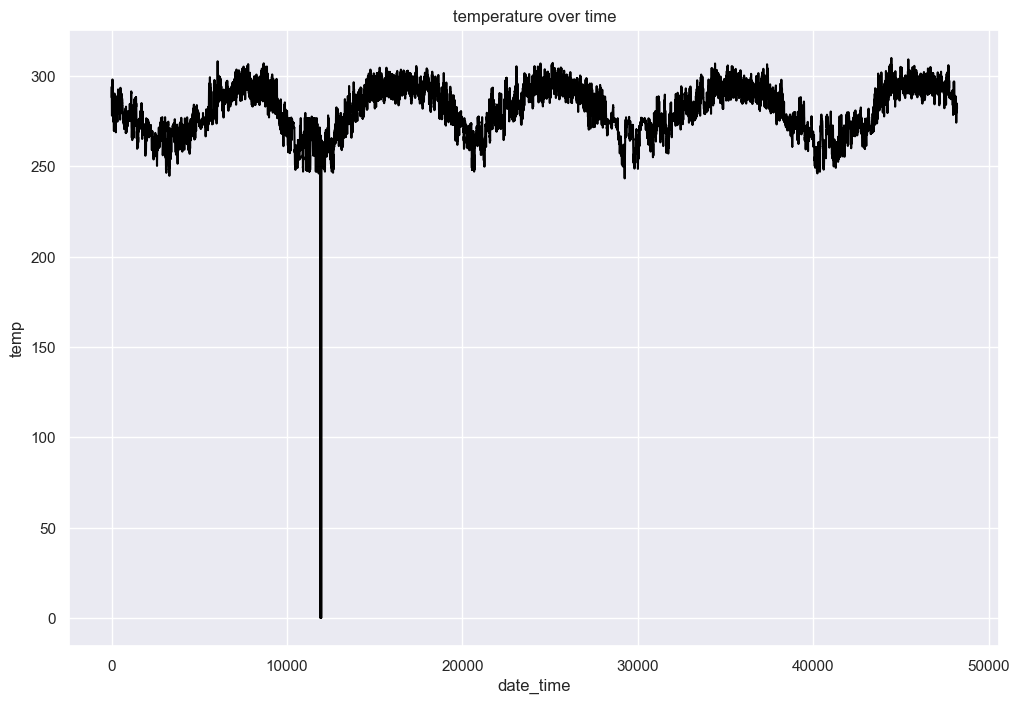

In [4]:
# Plotting temperature over time for entire dataset
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df['temp'], color = "black")

ax.set_xlabel('date_time');
ax.set_ylabel('temp')
ax.set_title('temperature over time');

It appears that the temperature follows an expected seasonal pattern except for a smattering of values that are listed as zero. Let's explore where those values are.

In [5]:
# Viewing zero values for the 'temp' column
df[df['temp'] == 0]

holiday  temp  rain_1h  snow_1h  clouds_all weather_main  \
11898    None   0.0      0.0      0.0           0        Clear   
11899    None   0.0      0.0      0.0           0        Clear   
11900    None   0.0      0.0      0.0           0        Clear   
11901    None   0.0      0.0      0.0           0        Clear   
11946    None   0.0      0.0      0.0           0        Clear   
11947    None   0.0      0.0      0.0           0        Clear   
11948    None   0.0      0.0      0.0           0        Clear   
11949    None   0.0      0.0      0.0           0        Clear   
11950    None   0.0      0.0      0.0           0        Clear   
11951    None   0.0      0.0      0.0           0        Clear   

      weather_description            date_time  traffic_volume  
11898        sky is clear  2014-01-31 03:00:00             361  
11899        sky is clear  2014-01-31 04:00:00             734  
11900        sky is clear  2014-01-31 05:00:00            2557  
11901        sky is clear  2014-01-31 06:00:00            5150  
11946        sky is clear  2014-02-02 03:00:00             291  
11947        sky is clear  2014-02-02 04:00:00             284  
11948        sky is clear  2014-02-02 05:00:00             434  
11949        sky is clear  2014-02-02 06:00:00             739  
11950        sky is clear  2014-02-02 07:00:00             962  
11951        sky is clear  2014-02-02 08:00:00            1670

There are two days in early 2014 that have a few hours with the temperature listed at zero. We know that the 'temp' column is listed in units of Kelvin; zero degrees Kelvin is the lowest limit of the thermodynamic temperature scale where atoms/particles stop moving so it is safe to assume this data is not accurate.

To fix this, we'll take a look at the recorded temperatures immediately before and after the inaccurate temperature data and fill them in with the average value.

In [6]:
# Viewing temperature values immediately before and after the inaccurate data
df['temp'].loc[11897:11902], df['temp'].loc[11945:11952]

(11897    255.93
 11898      0.00
 11899      0.00
 11900      0.00
 11901      0.00
 11902    255.93
 Name: temp, dtype: float64,
 11945    255.37
 11946      0.00
 11947      0.00
 11948      0.00
 11949      0.00
 11950      0.00
 11951      0.00
 11952    255.62
 Name: temp, dtype: float64)

In [7]:
# Setting inaccurate values to be equal to the average of the values immediately before and after
df['temp'].loc[11898:11901] = (df['temp'].loc[11897] + df['temp'].loc[11902]) / 2
df['temp'].loc[11946:11951] = (df['temp'].loc[11945] + df['temp'].loc[11952]) / 2

C:\Users\pschu\AppData\Local\Temp\ipykernel_14948\877917114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'].loc[11898:11901] = (df['temp'].loc[11897] + df['temp'].loc[11902]) / 2
C:\Users\pschu\AppData\Local\Temp\ipykernel_14948\877917114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'].loc[11946:11951] = (df['temp'].loc[11945] + df['temp'].loc[11952]) / 2


11897    255.93
11898    255.93
11899    255.93
11900    255.93
11901    255.93
11902    255.93
Name: temp, dtype: float64 11944    255.480
11945    255.370
11946    255.495
11947    255.495
11948    255.495
11949    255.495
11950    255.495
11951    255.495
11952    255.620
Name: temp, dtype: float64


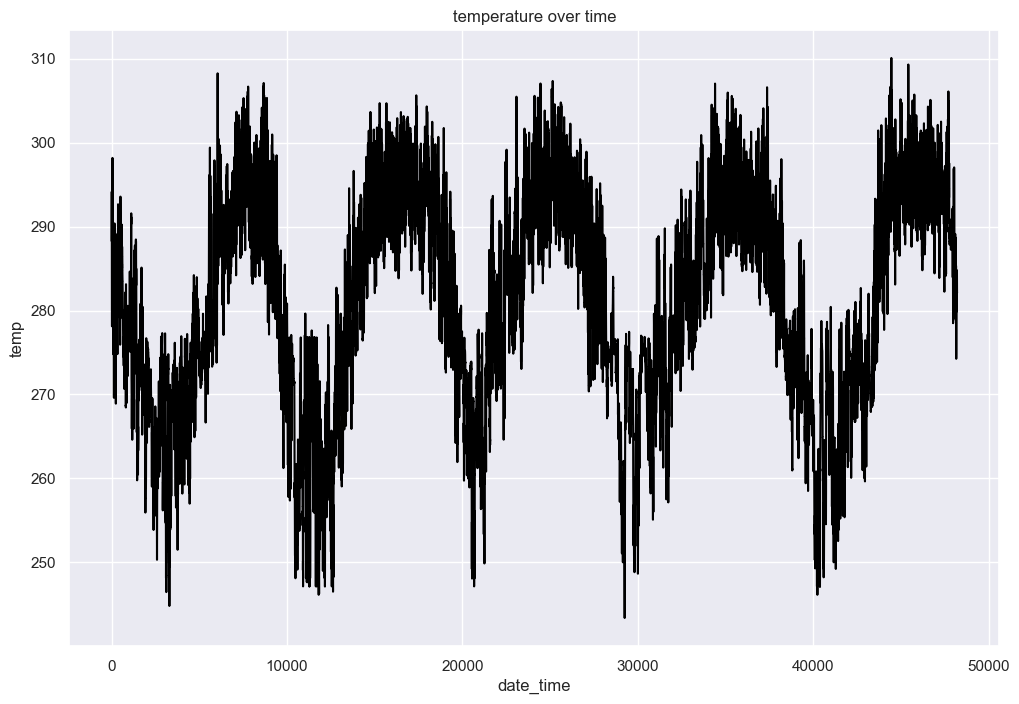

In [8]:
# Checking results
print(df['temp'].loc[11897:11902], df['temp'].loc[11944:11952])

# Plotting again for visual inspection
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df['temp'], color = "black", label='Temp')

ax.set_xlabel('date_time')
ax.set_ylabel('temp')
ax.set_title('temperature over time');

The plot looks better now that we've filled in the zero values for the temperature data. It follows the expected seasonal trend of decreasing temperatures as winter approaches and increasing temperatures as summer approaches. Next let's visually inspect the other numeric variables in the dataset: *rain_1h*, *snow_1h*, *clouds_all*, and *traffic_volume*.

Text(0.5, 1.0, 'traffic_volume')

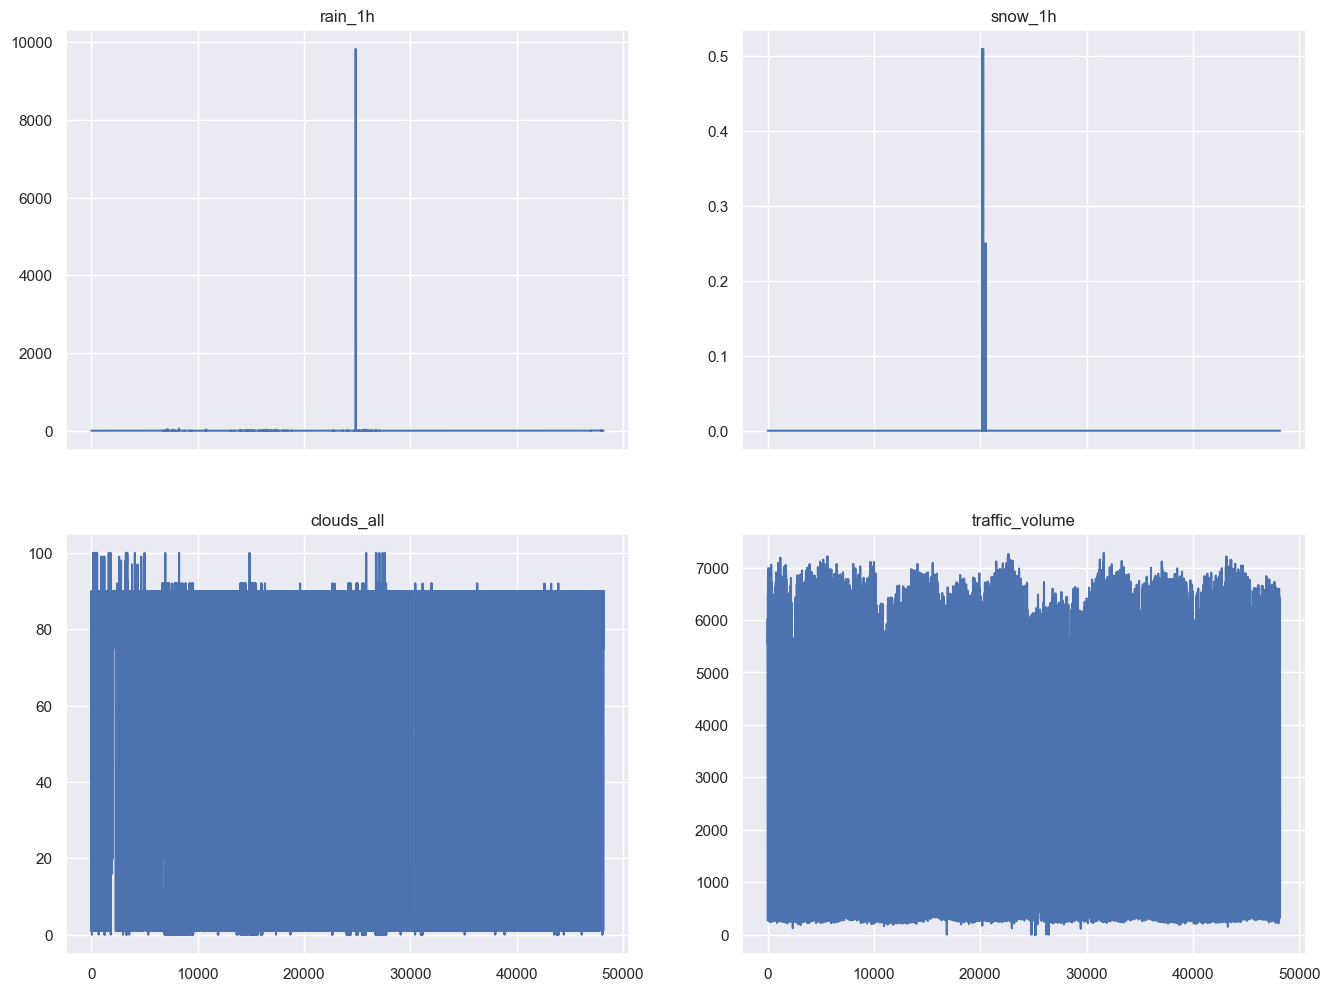

In [9]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,12))
axes[0, 0].plot(df['rain_1h']); axes[0, 0].set_title('rain_1h')
axes[0, 1].plot(df['snow_1h']); axes[0, 1].set_title('snow_1h')
axes[1, 0].plot(df['clouds_all']); axes[1, 0].set_title('clouds_all')
axes[1, 1].plot(df['traffic_volume']); axes[1, 1].set_title('traffic_volume')

*clouds_all* and *traffic_volume* appear to have normal values across the dataset but there are some odd looking spikes in the data for *rain_1h* and *snow_1h*. Both of these are measured in millimeters. It's unlikely that a singular day or hour produced almost 10,000 mm of rain and the snow values are suspiciously low for a state as far North as Minnesota.

To fix this, I obtained a dataset compiled by the [National Oceanic and Atmospheric Administration (NOAA)](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014922/detail). The dataset provides daily weather data gathered by a weather station at the Minneapolis St. Paul International Airport and will be used to fix the issues with the UCI dataset.

In [10]:
# Top 5 hourly rainfall values
df.sort_values(by='rain_1h', ascending=False).head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
24872    None  302.11  9831.30      0.0          75         Rain   
8247     None  289.10    55.63      0.0          68         Rain   
7179     None  295.82    44.45      0.0          76         Rain   
25779    None  297.71    31.75      0.0           0         Rain   
10807    None  264.50    28.70      0.0          64         Snow   

      weather_description            date_time  traffic_volume  
24872     very heavy rain  2016-07-11 17:00:00            5535  
8247      very heavy rain  2013-08-07 02:00:00             315  
7179      very heavy rain  2013-06-24 11:00:00            4802  
25779     very heavy rain  2016-08-16 17:00:00            4913  
10807          light snow  2013-12-19 23:00:00            1190

In [11]:
# Totalling snowfall values across entire dataset
df['snow_1h'].sum()

10.72

It's highly unlikely that 9,831 mm (approximately 32 feet!) of rain fell in one hour. It's also extremely unlikely that the total amount of snowfall listed across the entire dataset is 10.72 mm (0.42 inches). To fix this, we'll make some changes to the *date_time* column and the overall dataframe until we have a daily time series with complete and sensible values.

In [12]:
# Converting date_time column from object to datetime
df['date_time'] = pd.to_datetime(df['date_time'], infer_datetime_format=True)

# Extracting various date and time values from date_time column
df['date'] = df['date_time'].dt.date
df['year'] = df['date_time'].dt.year
df['month_day'] = df['date_time'].dt.strftime('%m-%d')
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['weekday'] = df['date_time'].dt.day_name()
df['hour'] = df['date_time'].dt.hour

# Converting newly created date column from object to datetime
df['date'] = pd.to_datetime(df['date'])

In [13]:
# Converting temp column to Fahrenheit values and rain/snow measurements to inches
df['temp'] = (df['temp'] - 273.15) * 9/5 + 32
df['rain_1h'] = df['rain_1h'] * 0.03937
df['snow_1h'] = df['snow_1h'] * 0.03937

# Renaming columns to show units of measurement
df = df.rename(columns={'rain_1h':'rain_in',
                        'snow_1h':'snow_in',
                        'clouds_all':'pct_cloud_cover'})

In [14]:
# Checking results
df.head()

holiday    temp  rain_in  snow_in  pct_cloud_cover weather_main  \
0    None  59.234      0.0      0.0               40       Clouds   
1    None  61.178      0.0      0.0               75       Clouds   
2    None  61.574      0.0      0.0               90       Clouds   
3    None  62.564      0.0      0.0               90       Clouds   
4    None  64.382      0.0      0.0               75       Clouds   

  weather_description           date_time  traffic_volume       date  year  \
0    scattered clouds 2012-10-02 09:00:00            5545 2012-10-02  2012   
1       broken clouds 2012-10-02 10:00:00            4516 2012-10-02  2012   
2     overcast clouds 2012-10-02 11:00:00            4767 2012-10-02  2012   
3     overcast clouds 2012-10-02 12:00:00            5026 2012-10-02  2012   
4       broken clouds 2012-10-02 13:00:00            4918 2012-10-02  2012   

  month_day  month  day  weekday  hour  
0     10-02     10    2  Tuesday     9  
1     10-02     10    2  Tuesday    10  
2     10-02     10    2  Tuesday    11  
3     10-02     10    2  Tuesday    12  
4     10-02     10    2  Tuesday    13

Our dataframe now contains values in Imperial units and we've broken the *date_time* column out into separate components. The next step is to set *date_time* as the index of our dataframe so we can resample to daily values.

In [15]:
# Setting date_time as index
df.set_index('date_time', inplace=True)

In [16]:
# Resampling to daily values
df_daily = df.resample('D').agg({'temp':'mean',
                                 'rain_in':'sum',
                                 'snow_in':'sum',
                                 'pct_cloud_cover':'mean',
                                 'traffic_volume':'sum',
                                 'holiday':'first',
                                 'year':'last',
                                 'month_day':'last',
                                 'month':'last',
                                 'day':'last',
                                 'weekday':'last'})

In [17]:
# After resampling, changing index name to just 'date'
df_daily.index.name='date'

# Checking results
df_daily.head()

temp  rain_in  snow_in  pct_cloud_cover  traffic_volume  \
date                                                                       
2012-10-02  63.056000      0.0      0.0        29.133333           63289   
2012-10-03  55.874300      0.0      0.0         3.850000           66345   
2012-10-04  61.173500      0.0      0.0        16.708333           89939   
2012-10-05  48.070727      0.0      0.0        75.000000           93336   
2012-10-06  40.272957      0.0      0.0        61.652174           74910   

           holiday    year month_day  month  day    weekday  
date                                                         
2012-10-02    None  2012.0     10-02   10.0  2.0    Tuesday  
2012-10-03    None  2012.0     10-03   10.0  3.0  Wednesday  
2012-10-04    None  2012.0     10-04   10.0  4.0   Thursday  
2012-10-05    None  2012.0     10-05   10.0  5.0     Friday  
2012-10-06    None  2012.0     10-06   10.0  6.0   Saturday

We now have a dataframe with the date as our index and average values for *temp* and *pct_cloud_cover* and totals for *rain_in*, *snow_in*, and *traffic_volume*. Let's take a look at some of these graphically.

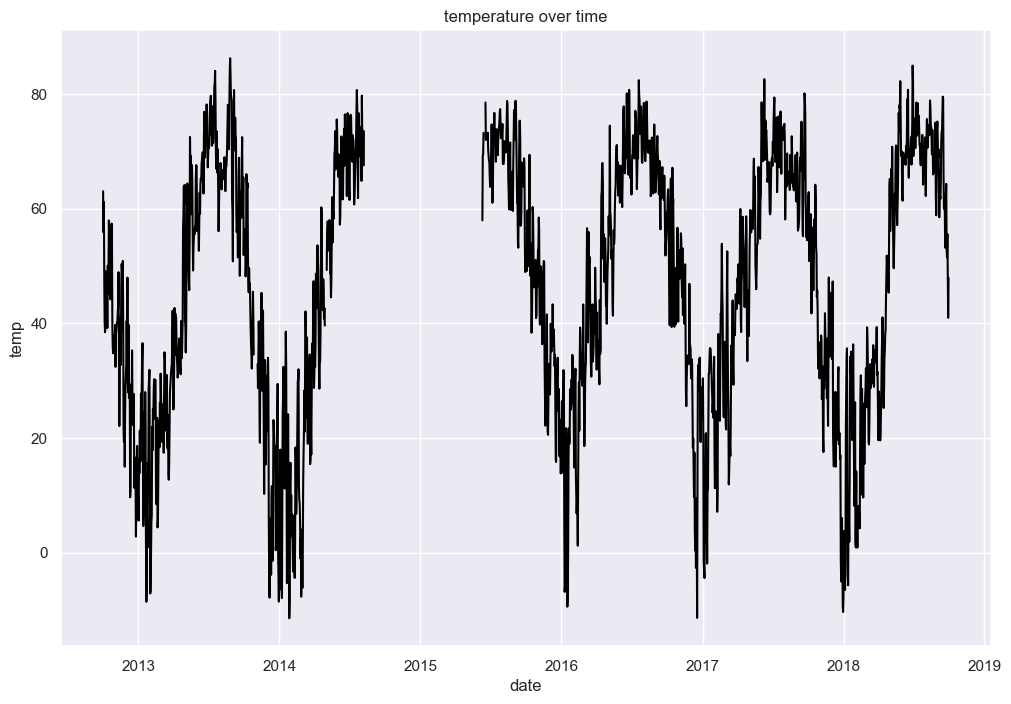

In [18]:
# Plotting temp for visual inspection
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df_daily['temp'], color = "black", label='Temp')

ax.set_xlabel('date')
ax.set_ylabel('temp')
ax.set_title('temperature over time');

Text(0.5, 1.0, 'traffic_volume')

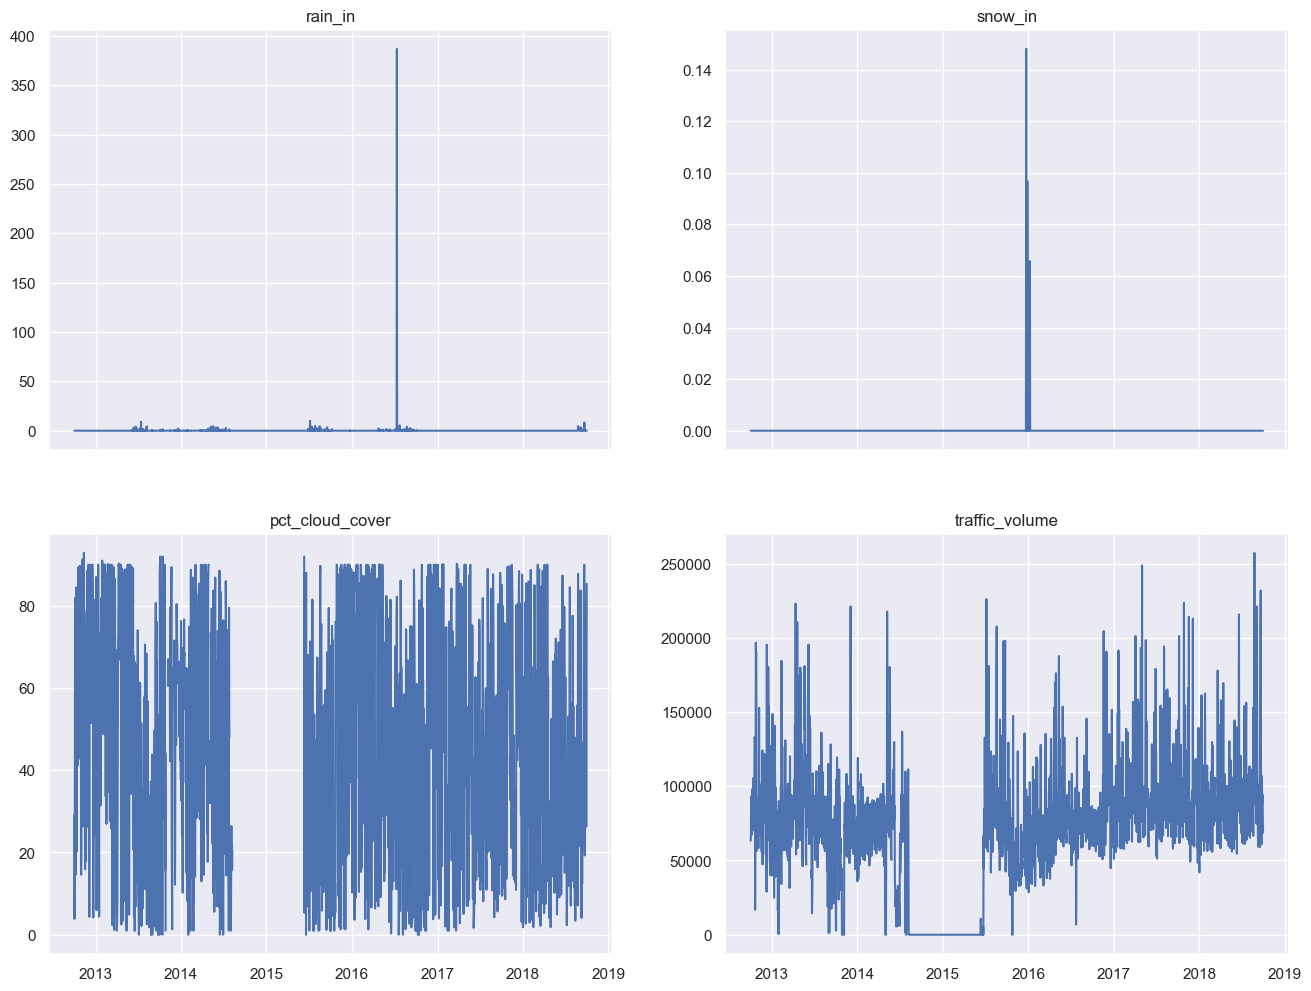

In [19]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,12))
axes[0, 0].plot(df_daily['rain_in']); axes[0, 0].set_title('rain_in')
axes[0, 1].plot(df_daily['snow_in']); axes[0, 1].set_title('snow_in')
axes[1, 0].plot(df_daily['pct_cloud_cover']); axes[1, 0].set_title('pct_cloud_cover')
axes[1, 1].plot(df_daily['traffic_volume']); axes[1, 1].set_title('traffic_volume')

We still have the same oddities in the rain and snow values, but it looks like we're missing a big chunk of data from temperature, cloud cover, and traffic volume. There's also some suspiciously low traffic volume values. We know from the [MNDOT Station 301 Monthly Report](https://dot.state.mn.us/traffic/data/reports/atr/Monthly_PDFs/Oct18/301.pdf) that this stretch of I-94 averages about 160,000 vehicles every day in both directions. We know that our dataset only contains westbound traffic and although we don't know what the directional traffic split is we can assume that westbound traffic makes up a decent proportion of the roughly 160,000 daily vehicles.

To find our cutoff point, we'll loop through the 10 - 20 percent quantiles and use one of those values as our cutoff.

In [20]:
# Looping through 10-20 percent quantiles
for i in range(10, 21):
    print(str(i) + '%' + ' Quantile: %f' % df_daily['traffic_volume'].quantile(i/100))

10% Quantile: 0.000000
11% Quantile: 0.000000
12% Quantile: 0.000000
13% Quantile: 0.000000
14% Quantile: 0.000000
15% Quantile: 0.000000
16% Quantile: 8101.120000
17% Quantile: 24404.600000
18% Quantile: 32938.980000
19% Quantile: 38435.100000
20% Quantile: 41966.000000


The first value that appears is the 16% quantile or 8,101. Let's proceed with replacing all traffic volume values lesser than this cutoff.

In [21]:
# Checking for low values in traffic_volume
df_daily[df_daily['traffic_volume'] < df_daily['traffic_volume'].quantile(.16)]

temp   rain_in  snow_in  pct_cloud_cover  traffic_volume  \
date                                                                        
2013-01-29  30.596000  0.000000      0.0            91.00             434   
2013-08-31  78.890000  0.000000      0.0             0.00            1321   
2013-09-01  61.610000  0.000000      0.0             1.00            1712   
2013-09-03  50.832500  0.000000      0.0            18.75            1462   
2013-10-01  51.935000  0.000000      0.0             0.00            3969   
...               ...       ...      ...              ...             ...   
2015-06-23        NaN  0.000000      0.0              NaN               0   
2015-10-24        NaN  0.000000      0.0              NaN               0   
2015-10-25        NaN  0.000000      0.0              NaN               0   
2015-10-26        NaN  0.000000      0.0              NaN               0   
2016-07-23  73.023029  5.458651      0.0            63.60            6753   

           holiday    year month_day  month   day   weekday  
date                                                         
2013-01-29    None  2013.0     01-29    1.0  29.0   Tuesday  
2013-08-31    None  2013.0     08-31    8.0  31.0  Saturday  
2013-09-01    None  2013.0     09-01    9.0   1.0    Sunday  
2013-09-03    None  2013.0     09-03    9.0   3.0   Tuesday  
2013-10-01    None  2013.0     10-01   10.0   1.0   Tuesday  
...            ...     ...       ...    ...   ...       ...  
2015-06-23    None     NaN      None    NaN   NaN      None  
2015-10-24    None     NaN      None    NaN   NaN      None  
2015-10-25    None     NaN      None    NaN   NaN      None  
2015-10-26    None     NaN      None    NaN   NaN      None  
2016-07-23    None  2016.0     07-23    7.0  23.0  Saturday  

[351 rows x 11 columns]

351 days of low *traffic_volume* values, including some zeroes. That can't be right. To fix this, our best option is to find the average values from the same combinations of month and day that are present in the rest of our dataset. First, let's cast the *year*, *month*, and *day* columns as integers to get rid of those decimals.

In [22]:
df_daily['year'] = df_daily['year'].fillna(0).astype(int)
df_daily['month'] = df_daily['month'].fillna(0).astype(int)
df_daily['day'] = df_daily['day'].fillna(0).astype(int)

In [23]:
# Checking number of rows in df_daily
df_daily.shape

(2190, 11)

In [24]:
# Creating new dataframe with no low values and checking new number of rows
df_daily_avg = df_daily[df_daily['traffic_volume'] > df_daily['traffic_volume'].quantile(.16)]
df_daily_avg.shape

(1839, 11)

2190 - 1839 = 351, that checks out. Next we'll group by month and day to find the average *traffic_volume* and *pct_cloud_cover* values for each of our non-cutoff values.

In [25]:
# Group by month and day, calculate the mean, reset index, and check results
df_daily_avg = df_daily_avg.groupby(['month_day']).agg({'traffic_volume':'mean',
                                                        'pct_cloud_cover':'mean'})
df_daily_avg = df_daily_avg.reset_index()
df_daily_avg['traffic_volume'] = df_daily_avg['traffic_volume'].astype('int')
df_daily_avg['pct_cloud_cover'] = df_daily_avg['pct_cloud_cover'].astype('int')

df_daily_avg

month_day  traffic_volume  pct_cloud_cover
0       01-01           40675               36
1       01-02           79661               47
2       01-03           92301               60
3       01-04           82860               41
4       01-05           66190               27
..        ...             ...              ...
361     12-27           68401               44
362     12-28           90395               62
363     12-29           78483               67
364     12-30           68243               51
365     12-31           70880               38

[366 rows x 3 columns]

Once again we'll reset the index of our <b>df_daily</b> dataframe and extract the month and day values so we can merge it with our <b>df_daily_avg</b> dataframe.

In [26]:
# Making new dataframe with low values for traffic_volume
df_fix = df_daily[df_daily['traffic_volume'] < df_daily['traffic_volume'].quantile(.16)]

# Resetting index and creating month_day column
df_fix = df_fix.reset_index()
df_fix['month_day'] = df_fix['date'].dt.strftime('%m-%d')

# Checking results
df_fix

date       temp   rain_in  snow_in  pct_cloud_cover  traffic_volume  \
0   2013-01-29  30.596000  0.000000      0.0            91.00             434   
1   2013-08-31  78.890000  0.000000      0.0             0.00            1321   
2   2013-09-01  61.610000  0.000000      0.0             1.00            1712   
3   2013-09-03  50.832500  0.000000      0.0            18.75            1462   
4   2013-10-01  51.935000  0.000000      0.0             0.00            3969   
..         ...        ...       ...      ...              ...             ...   
346 2015-06-23        NaN  0.000000      0.0              NaN               0   
347 2015-10-24        NaN  0.000000      0.0              NaN               0   
348 2015-10-25        NaN  0.000000      0.0              NaN               0   
349 2015-10-26        NaN  0.000000      0.0              NaN               0   
350 2016-07-23  73.023029  5.458651      0.0            63.60            6753   

    holiday  year month_day  month  day   weekday  
0      None  2013     01-29      1   29   Tuesday  
1      None  2013     08-31      8   31  Saturday  
2      None  2013     09-01      9    1    Sunday  
3      None  2013     09-03      9    3   Tuesday  
4      None  2013     10-01     10    1   Tuesday  
..      ...   ...       ...    ...  ...       ...  
346    None     0     06-23      0    0      None  
347    None     0     10-24      0    0      None  
348    None     0     10-25      0    0      None  
349    None     0     10-26      0    0      None  
350    None  2016     07-23      7   23  Saturday  

[351 rows x 12 columns]

In [27]:
# Merging dataframes and checking results
merge = pd.merge(df_fix, df_daily_avg, on ='month_day', how='inner')
merge

date       temp   rain_in  snow_in  pct_cloud_cover_x  \
0   2013-01-29  30.596000  0.000000      0.0               91.0   
1   2015-01-29        NaN  0.000000      0.0                NaN   
2   2013-08-31  78.890000  0.000000      0.0                0.0   
3   2014-08-31        NaN  0.000000      0.0                NaN   
4   2013-09-01  61.610000  0.000000      0.0                1.0   
..         ...        ...       ...      ...                ...   
346 2015-06-19  78.542600  0.000000      0.0                0.0   
347 2015-06-20  71.994200  0.000000      0.0               88.0   
348 2015-06-21        NaN  0.000000      0.0                NaN   
349 2015-06-23        NaN  0.000000      0.0                NaN   
350 2016-07-23  73.023029  5.458651      0.0               63.6   

     traffic_volume_x holiday  year month_day  month  day   weekday  \
0                 434    None  2013     01-29      1   29   Tuesday   
1                   0    None     0     01-29      0    0      None   
2                1321    None  2013     08-31      8   31  Saturday   
3                   0    None     0     08-31      0    0      None   
4                1712    None  2013     09-01      9    1    Sunday   
..                ...     ...   ...       ...    ...  ...       ...   
346              4681    None  2015     06-19      6   19    Friday   
347              4045    None  2015     06-20      6   20  Saturday   
348                 0    None     0     06-21      0    0      None   
349                 0    None     0     06-23      0    0      None   
350              6753    None  2016     07-23      7   23  Saturday   

     traffic_volume_y  pct_cloud_cover_y  
0               76910                 39  
1               76910                 39  
2               99506                 24  
3               99506                 24  
4               79378                 25  
..                ...                ...  
346             88133                 52  
347             70593                 29  
348             61849                 22  
349             68452                 34  
350             85537                 23  

[351 rows x 14 columns]

We've successsfully added the average *traffic_volume* and *pct_cloud_cover* values for our values beneath the cutoff, now we'll drop all the unnecessary columns so it's easier to perform another merge with our <b>df_daily</b> dataframe.

In [28]:
# Keeping just the relevant columns
merge = merge[['date', 'traffic_volume_y', 'pct_cloud_cover_y']]
merge

date  traffic_volume_y  pct_cloud_cover_y
0   2013-01-29             76910                 39
1   2015-01-29             76910                 39
2   2013-08-31             99506                 24
3   2014-08-31             99506                 24
4   2013-09-01             79378                 25
..         ...               ...                ...
346 2015-06-19             88133                 52
347 2015-06-20             70593                 29
348 2015-06-21             61849                 22
349 2015-06-23             68452                 34
350 2016-07-23             85537                 23

[351 rows x 3 columns]

In [29]:
# Resetting df_daily index for merge and performing merge
df_daily.reset_index(inplace=True)
df_daily = pd.merge(df_daily, merge, on ='date', how='left')

# Checking results
df_daily

date       temp   rain_in  snow_in  pct_cloud_cover  \
0    2012-10-02  63.056000  0.000000      0.0        29.133333   
1    2012-10-03  55.874300  0.000000      0.0         3.850000   
2    2012-10-04  61.173500  0.000000      0.0        16.708333   
3    2012-10-05  48.070727  0.000000      0.0        75.000000   
4    2012-10-06  40.272957  0.000000      0.0        61.652174   
...         ...        ...       ...      ...              ...   
2185 2018-09-26  51.522500  0.009843      0.0        39.833333   
2186 2018-09-27  55.613120  0.019685      0.0        61.200000   
2187 2018-09-28  47.189000  0.000000      0.0        26.250000   
2188 2018-09-29  40.973360  0.009843      0.0        57.360000   
2189 2018-09-30  47.940385  0.009843      0.0        85.384615   

      traffic_volume holiday  year month_day  month  day    weekday  \
0              63289    None  2012     10-02     10    2    Tuesday   
1              66345    None  2012     10-03     10    3  Wednesday   
2              89939    None  2012     10-04     10    4   Thursday   
3              93336    None  2012     10-05     10    5     Friday   
4              74910    None  2012     10-06     10    6   Saturday   
...              ...     ...   ...       ...    ...  ...        ...   
2185           88627    None  2018     09-26      9   26  Wednesday   
2186           94434    None  2018     09-27      9   27   Thursday   
2187           92518    None  2018     09-28      9   28     Friday   
2188           76242    None  2018     09-29      9   29   Saturday   
2189           68785    None  2018     09-30      9   30     Sunday   

      traffic_volume_y  pct_cloud_cover_y  
0                  NaN                NaN  
1                  NaN                NaN  
2                  NaN                NaN  
3                  NaN                NaN  
4                  NaN                NaN  
...                ...                ...  
2185               NaN                NaN  
2186               NaN                NaN  
2187               NaN                NaN  
2188               NaN                NaN  
2189               NaN                NaN  

[2190 rows x 14 columns]

In [30]:
# Replacing low traffic volumes with their daily averages
df_daily.loc[df_daily['traffic_volume'] < df_daily['traffic_volume'].quantile(.16),
             'traffic_volume'] = df_daily['traffic_volume_y']

# Replacing null cloud cover values with their daily averages
df_daily.loc[df_daily['pct_cloud_cover'].isnull(), 'pct_cloud_cover'] = df_daily['pct_cloud_cover_y']

In [31]:
# Dropping unnecessary columns
df_daily.drop(['traffic_volume_y', 'pct_cloud_cover_y'], axis=1, inplace=True)

In [32]:
# Checking statistical values for our modified columns
df_daily[['pct_cloud_cover', 'traffic_volume']].describe()

pct_cloud_cover  traffic_volume
count      2190.000000     2190.000000
mean         45.742471    85492.527397
std          26.538566    29113.950551
min           0.000000    10676.000000
25%          23.218750    68671.750000
50%          46.000000    84564.500000
75%          66.394828    94134.750000
max          92.880000   257191.000000

The mean values for the two columns we've modified are reasonable. Remember earlier when we saw approximately 32 feet of rainfall in one hour and the total amount of snowfall listed across the entire dataset as 0.42 inches? In addition we saw that there is a big chunk of temperature data missing. Let's look at the NOAA dataset and see how we can use that to complete our dataset.

In [33]:
# Viewing column data for NOAA dataset
df_noaa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATION    2190 non-null   object 
 1   NAME       2190 non-null   object 
 2   LATITUDE   2190 non-null   float64
 3   LONGITUDE  2190 non-null   float64
 4   ELEVATION  2190 non-null   float64
 5   DATE       2190 non-null   object 
 6   AWND       2190 non-null   float64
 7   PGTM       2 non-null      float64
 8   PRCP       2190 non-null   float64
 9   SNOW       2190 non-null   float64
 10  SNWD       2190 non-null   float64
 11  TAVG       2009 non-null   float64
 12  TMAX       2190 non-null   int64  
 13  TMIN       2190 non-null   int64  
 14  WDF2       2190 non-null   int64  
 15  WDF5       2189 non-null   float64
 16  WSF2       2190 non-null   float64
 17  WSF5       2189 non-null   float64
 18  WT01       760 non-null    float64
 19  WT02       35 non-null     float64
 20  WT03    

In [34]:
# Making new dataframe with just the relevant columns
df_noaa_fix = df_noaa[['DATE', 'PRCP', 'SNOW', 'TAVG']]
df_noaa_fix

DATE  PRCP  SNOW  TAVG
0     2012-10-02   0.0   0.0   NaN
1     2012-10-03   0.0   0.0   NaN
2     2012-10-04   0.0   0.0   NaN
3     2012-10-05   0.0   0.0   NaN
4     2012-10-06   0.0   0.0   NaN
...          ...   ...   ...   ...
2185  2018-09-26   0.0   0.0  52.0
2186  2018-09-27   0.0   0.0  58.0
2187  2018-09-28   0.0   0.0  50.0
2188  2018-09-29   0.0   0.0  43.0
2189  2018-09-30   0.0   0.0  48.0

[2190 rows x 4 columns]

In [35]:
# Converting to datetime value
df_noaa_fix['DATE'] = pd.to_datetime(df_noaa_fix['DATE'], infer_datetime_format=True)

# Renaming column to match df_daily
df_noaa_fix.rename(columns={'DATE':'date'}, inplace=True)

# Checking results
df_noaa_fix

C:\Users\pschu\AppData\Local\Temp\ipykernel_14948\1046111135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noaa_fix['DATE'] = pd.to_datetime(df_noaa_fix['DATE'], infer_datetime_format=True)
C:\Users\pschu\AppData\Local\Temp\ipykernel_14948\1046111135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noaa_fix.rename(columns={'DATE':'date'}, inplace=True)


date  PRCP  SNOW  TAVG
0    2012-10-02   0.0   0.0   NaN
1    2012-10-03   0.0   0.0   NaN
2    2012-10-04   0.0   0.0   NaN
3    2012-10-05   0.0   0.0   NaN
4    2012-10-06   0.0   0.0   NaN
...         ...   ...   ...   ...
2185 2018-09-26   0.0   0.0  52.0
2186 2018-09-27   0.0   0.0  58.0
2187 2018-09-28   0.0   0.0  50.0
2188 2018-09-29   0.0   0.0  43.0
2189 2018-09-30   0.0   0.0  48.0

[2190 rows x 4 columns]

Excellent - we now have a dataframe with a matching *date* column and rain, snow, and temperature values that can be used to fill in the gaps in <b>df_daily</b>.

In [36]:
# Merging dataframes
df_daily = pd.merge(df_daily, df_noaa_fix, on ='date', how='left')
df_daily

date       temp   rain_in  snow_in  pct_cloud_cover  \
0    2012-10-02  63.056000  0.000000      0.0        29.133333   
1    2012-10-03  55.874300  0.000000      0.0         3.850000   
2    2012-10-04  61.173500  0.000000      0.0        16.708333   
3    2012-10-05  48.070727  0.000000      0.0        75.000000   
4    2012-10-06  40.272957  0.000000      0.0        61.652174   
...         ...        ...       ...      ...              ...   
2185 2018-09-26  51.522500  0.009843      0.0        39.833333   
2186 2018-09-27  55.613120  0.019685      0.0        61.200000   
2187 2018-09-28  47.189000  0.000000      0.0        26.250000   
2188 2018-09-29  40.973360  0.009843      0.0        57.360000   
2189 2018-09-30  47.940385  0.009843      0.0        85.384615   

      traffic_volume holiday  year month_day  month  day    weekday  PRCP  \
0              63289    None  2012     10-02     10    2    Tuesday   0.0   
1              66345    None  2012     10-03     10    3  Wednesday   0.0   
2              89939    None  2012     10-04     10    4   Thursday   0.0   
3              93336    None  2012     10-05     10    5     Friday   0.0   
4              74910    None  2012     10-06     10    6   Saturday   0.0   
...              ...     ...   ...       ...    ...  ...        ...   ...   
2185           88627    None  2018     09-26      9   26  Wednesday   0.0   
2186           94434    None  2018     09-27      9   27   Thursday   0.0   
2187           92518    None  2018     09-28      9   28     Friday   0.0   
2188           76242    None  2018     09-29      9   29   Saturday   0.0   
2189           68785    None  2018     09-30      9   30     Sunday   0.0   

      SNOW  TAVG  
0      0.0   NaN  
1      0.0   NaN  
2      0.0   NaN  
3      0.0   NaN  
4      0.0   NaN  
...    ...   ...  
2185   0.0  52.0  
2186   0.0  58.0  
2187   0.0  50.0  
2188   0.0  43.0  
2189   0.0  48.0  

[2190 rows x 15 columns]

In [37]:
# Replacing null temperature values with values from NOAA
df_daily.loc[df_daily['temp'].isnull(), 'temp'] = df_daily['TAVG']

# Replacing all rainfall and snowfall values with values from NOAA
df_daily['snow_in'] = df_daily['SNOW']
df_daily['rain_in'] = df_daily['PRCP']

In [38]:
# Dropping unnecessary columns
df_daily.drop(['PRCP', 'SNOW', 'TAVG'], axis=1, inplace=True)

# Checking results
df_daily.head()

date       temp  rain_in  snow_in  pct_cloud_cover  traffic_volume  \
0 2012-10-02  63.056000      0.0      0.0        29.133333           63289   
1 2012-10-03  55.874300      0.0      0.0         3.850000           66345   
2 2012-10-04  61.173500      0.0      0.0        16.708333           89939   
3 2012-10-05  48.070727      0.0      0.0        75.000000           93336   
4 2012-10-06  40.272957      0.0      0.0        61.652174           74910   

  holiday  year month_day  month  day    weekday  
0    None  2012     10-02     10    2    Tuesday  
1    None  2012     10-03     10    3  Wednesday  
2    None  2012     10-04     10    4   Thursday  
3    None  2012     10-05     10    5     Friday  
4    None  2012     10-06     10    6   Saturday

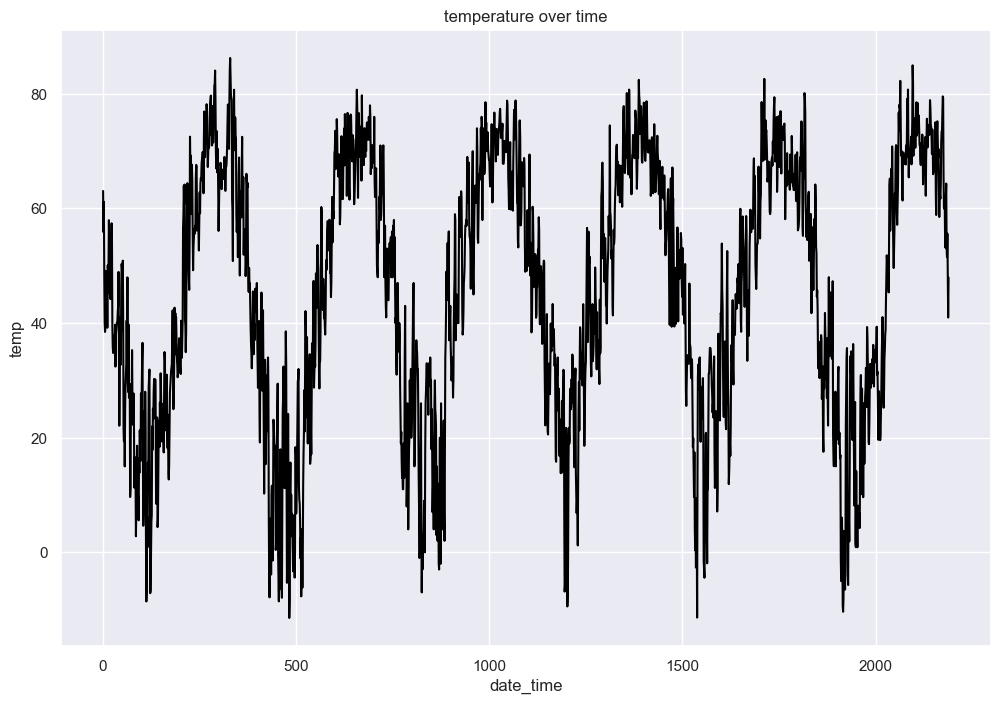

In [39]:
# Plotting temp for visual inspection
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df_daily['temp'], color = "black", label='Temp')

ax.set_xlabel('date_time')
ax.set_ylabel('temp')
ax.set_title('temperature over time');

Text(0.5, 1.0, 'traffic_volume')

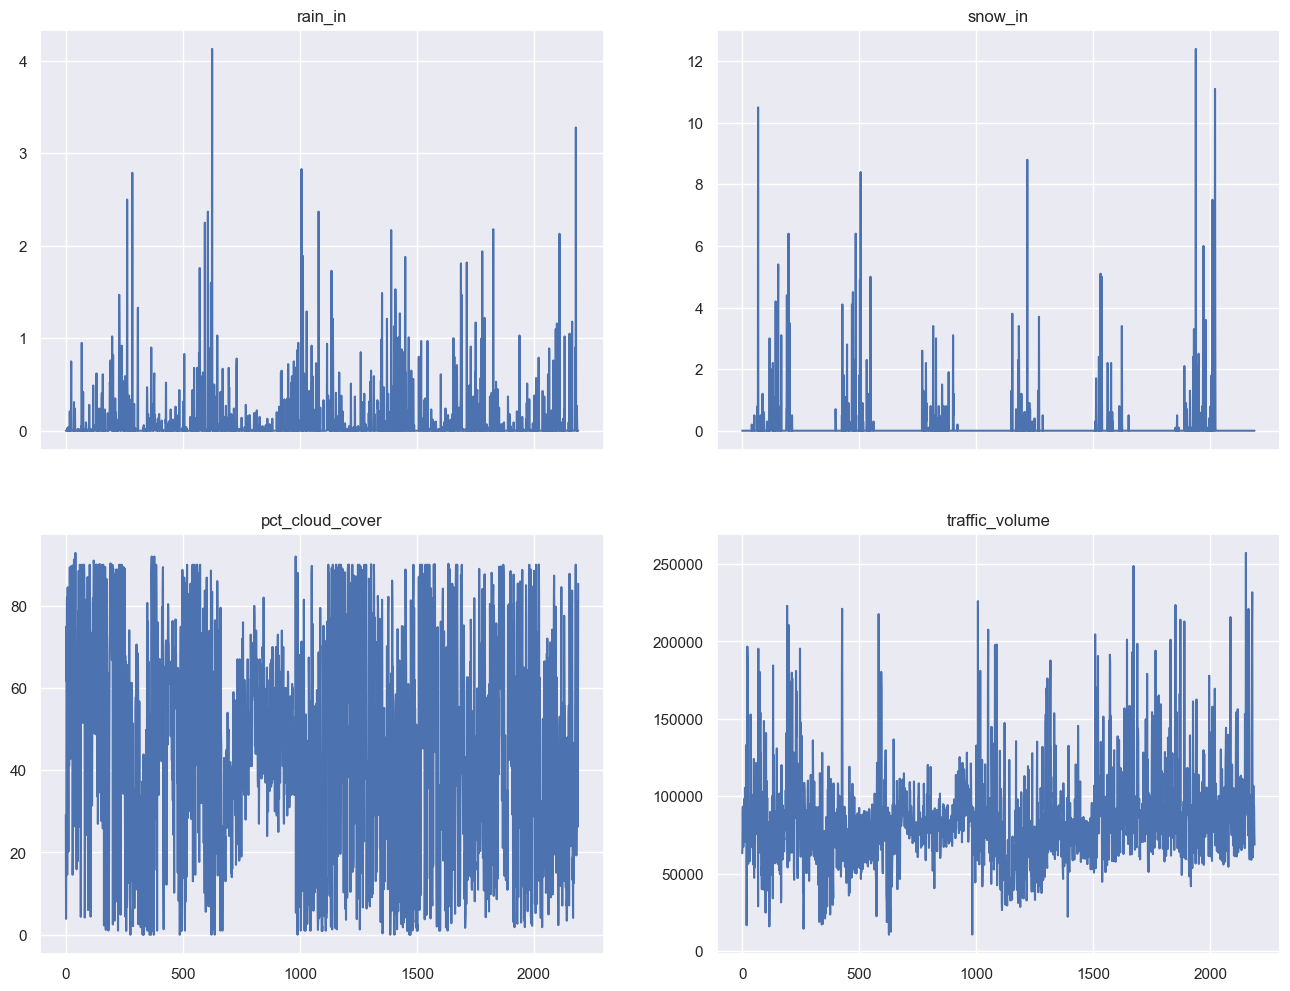

In [40]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,12))
axes[0, 0].plot(df_daily['rain_in']); axes[0, 0].set_title('rain_in')
axes[0, 1].plot(df_daily['snow_in']); axes[0, 1].set_title('snow_in')
axes[1, 0].plot(df_daily['pct_cloud_cover']); axes[1, 0].set_title('pct_cloud_cover')
axes[1, 1].plot(df_daily['traffic_volume']); axes[1, 1].set_title('traffic_volume')

In [41]:
# Calculating average daily temperature  and average yearly rain/snow values
print(df_daily['temp'].sum() / (len(df_daily.index)))
print(df_daily['rain_in'].sum() / (len(df_daily.index) / 365))
print(df_daily['snow_in'].sum() / (len(df_daily.index) / 365))

45.90382363831284
34.625
52.81666666666666


In [42]:
# Checking for any missing values after modifying df_daily
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2190 non-null   datetime64[ns]
 1   temp             2190 non-null   float64       
 2   rain_in          2190 non-null   float64       
 3   snow_in          2190 non-null   float64       
 4   pct_cloud_cover  2190 non-null   float64       
 5   traffic_volume   2190 non-null   int64         
 6   holiday          1860 non-null   object        
 7   year             2190 non-null   int32         
 8   month_day        1860 non-null   object        
 9   month            2190 non-null   int32         
 10  day              2190 non-null   int32         
 11  weekday          1860 non-null   object        
dtypes: datetime64[ns](1), float64(4), int32(3), int64(1), object(3)
memory usage: 261.3+ KB


Due to the missing data, we don't have a complete set of values for things like *holiday*, *month_day*, and *weekday*. We'll run the same code we did earlier to extract these values from *date_time*.

In [43]:
# Extracting various date and time values from date column
df_daily['year'] = df_daily['date'].dt.year
df_daily['month_day'] = df_daily['date'].dt.strftime('%m-%d')
df_daily['month'] = df_daily['date'].dt.month
df_daily['day'] = df_daily['date'].dt.day
df_daily['weekday'] = df_daily['date'].dt.day_name()

In [44]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2190 non-null   datetime64[ns]
 1   temp             2190 non-null   float64       
 2   rain_in          2190 non-null   float64       
 3   snow_in          2190 non-null   float64       
 4   pct_cloud_cover  2190 non-null   float64       
 5   traffic_volume   2190 non-null   int64         
 6   holiday          1860 non-null   object        
 7   year             2190 non-null   int64         
 8   month_day        2190 non-null   object        
 9   month            2190 non-null   int64         
 10  day              2190 non-null   int64         
 11  weekday          2190 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(4), object(3)
memory usage: 287.0+ KB


We're so close but we're still missing whether or not the days we added are a holiday. Fortunately for us, there is a Python library we can use to create a dataframe with dates and US holidays.

In [45]:
df_daily[df_daily['holiday'].isnull()]

date  temp  rain_in  snow_in  pct_cloud_cover  traffic_volume  \
391  2013-10-28  40.0     0.00      0.0             60.0           91600   
392  2013-10-29  37.0     0.03      0.0             76.0           75259   
393  2013-10-30  43.0     0.13      0.0             56.0           76979   
394  2013-10-31  46.0     0.00      0.0             58.0           79196   
395  2013-11-01  43.0     0.00      0.0             35.0           89615   
...         ...   ...      ...      ...              ...             ...   
992  2015-06-21  75.0     0.00      0.0             22.0           61849   
994  2015-06-23  70.0     0.00      0.0             34.0           68452   
1117 2015-10-24  52.0     0.24      0.0             56.0           99009   
1118 2015-10-25  47.0     0.01      0.0             56.0          100645   
1119 2015-10-26  52.0     0.01      0.0             72.0          108399   

     holiday  year month_day  month  day    weekday  
391     None  2013     10-28     10   28     Monday  
392     None  2013     10-29     10   29    Tuesday  
393     None  2013     10-30     10   30  Wednesday  
394     None  2013     10-31     10   31   Thursday  
395     None  2013     11-01     11    1     Friday  
...      ...   ...       ...    ...  ...        ...  
992     None  2015     06-21      6   21     Sunday  
994     None  2015     06-23      6   23    Tuesday  
1117    None  2015     10-24     10   24   Saturday  
1118    None  2015     10-25     10   25     Sunday  
1119    None  2015     10-26     10   26     Monday  

[330 rows x 12 columns]

In [46]:
# pip install --upgrade holidays

In [47]:
import holidays

# Looping through each year in our dataset to create a dataframe of holidays
holiday_list = []
for holiday in holidays.US(years=[2013, 2014, 2015]).items():
    holiday_list.append(holiday)

df_holidays = pd.DataFrame(holiday_list, columns=['date', 'holiday_fix'])

# Converting to datetime value
df_holidays['date'] = pd.to_datetime(df_holidays['date'], infer_datetime_format=True)

In [48]:
# Merging dataframes
df_daily = pd.merge(df_daily, df_holidays, on ='date', how='left')

In [49]:
# Replacing any null holiday values with holiday_fix
df_daily.loc[df_daily['holiday'].isnull(), 'holiday'] = df_daily['holiday_fix']

# Replacing any remaining null values with 'None' to match rest of dataframe
df_daily['holiday'] = df_daily['holiday'].replace(np.nan, 'None')

# Dropping holiday_fix column
df_daily.drop('holiday_fix', axis=1, inplace=True)

In [50]:
df_daily['holiday'].value_counts()

None                          2128
Columbus Day                     6
Veterans Day                     6
Christmas Day                    6
Memorial Day                     6
Labor Day                        6
Thanksgiving Day                 5
New Years Day                    5
Washingtons Birthday             5
Independence Day                 5
State Fair                       5
Martin Luther King Jr Day        3
Thanksgiving                     1
New Year's Day                   1
Martin Luther King Jr. Day       1
Washington's Birthday            1
Name: holiday, dtype: int64

We're still missing some values and some of the holiday names are different.

In [51]:
# Ensuring consistency across holiday names
df_daily['holiday'] = df_daily['holiday'].replace(['Washingtons Birthday',
                                                   'New Years Day',
                                                   'Martin Luther King Jr Day',
                                                   'Thanksgiving',
                                                   'Veterans Day'],
                                                  ["Washington's Birthday",
                                                   "New Year's Day",
                                                   "Martin Luther King Jr. Day",
                                                   "Thanksgiving Day",
                                                   "Veteran's Day"])

In [52]:
# Finding missing State Fair holiday
df_daily[(df_daily['holiday'] == 'State Fair')]

date       temp  rain_in  snow_in  pct_cloud_cover  traffic_volume  \
324  2013-08-22  77.750000     0.00      0.0        27.958333           92767   
1059 2015-08-27  65.463500     0.00      0.0        24.333333           92247   
1423 2016-08-25  65.132750     0.00      0.0        17.375000           86688   
1787 2017-08-24  63.811040     0.01      0.0        54.280000           96582   
2151 2018-08-23  68.323217     0.00      0.0        33.260870           91496   

         holiday  year month_day  month  day   weekday  
324   State Fair  2013     08-22      8   22  Thursday  
1059  State Fair  2015     08-27      8   27  Thursday  
1423  State Fair  2016     08-25      8   25  Thursday  
1787  State Fair  2017     08-24      8   24  Thursday  
2151  State Fair  2018     08-23      8   23  Thursday

In [53]:
# Finding missing Independence Day holiday
df_daily[(df_daily['holiday'] == 'Independence Day')]

date     temp  rain_in  snow_in  pct_cloud_cover  traffic_volume  \
275  2013-07-04  71.0870     0.00      0.0         6.041667           50356   
1004 2015-07-03  67.8065     0.00      0.0         1.000000           64366   
1371 2016-07-04  69.6050     0.00      0.0        48.333333           46678   
1736 2017-07-04  75.0950     0.00      0.0        20.958333           51205   
2101 2018-07-04  75.7172     0.67      0.0        36.166667           61798   

               holiday  year month_day  month  day    weekday  
275   Independence Day  2013     07-04      7    4   Thursday  
1004  Independence Day  2015     07-03      7    3     Friday  
1371  Independence Day  2016     07-04      7    4     Monday  
1736  Independence Day  2017     07-04      7    4    Tuesday  
2101  Independence Day  2018     07-04      7    4  Wednesday

In [54]:
# Finding missing Martin Luther King Jr. Day holiday
df_daily[(df_daily['holiday'] == 'Martin Luther King Jr. Day')]

date       temp  rain_in  snow_in  pct_cloud_cover  traffic_volume  \
475  2014-01-20  14.776348     0.01      0.2        61.260870           64242   
839  2015-01-19  30.000000     0.01      0.1        46.000000           80264   
1567 2017-01-16  22.014500     0.12      0.0        50.675000          111604   
1931 2018-01-15   6.204773     0.00      0.0        85.454545          114242   

                         holiday  year month_day  month  day weekday  
475   Martin Luther King Jr. Day  2014     01-20      1   20  Monday  
839   Martin Luther King Jr. Day  2015     01-19      1   19  Monday  
1567  Martin Luther King Jr. Day  2017     01-16      1   16  Monday  
1931  Martin Luther King Jr. Day  2018     01-15      1   15  Monday

In [55]:
# Reset index to easily fill in missing holiday values
df_daily.set_index('date', inplace=True)

# Filling in missing holidays
df_daily.loc['2013-01-21', 'holiday'] = 'Martin Luther King Jr. Day'
df_daily.loc['2014-07-04', 'holiday'] = 'Independence Day'
df_daily.loc['2014-08-21', 'holiday'] = 'State Fair'
df_daily.loc['2016-01-18', 'holiday'] = 'Martin Luther King Jr. Day'

In [56]:
df_daily['holiday'].value_counts()

None                          2124
Columbus Day                     6
Veteran's Day                    6
Thanksgiving Day                 6
Christmas Day                    6
New Year's Day                   6
Martin Luther King Jr. Day       6
Washington's Birthday            6
Memorial Day                     6
Independence Day                 6
State Fair                       6
Labor Day                        6
Name: holiday, dtype: int64

We've done it! At last we have a dataset with complete, sensible daily values. We can finally begin modelling.

In [57]:
# Saving dataframe as .csv file for future use
# df_daily.to_csv('data/complete_daily_values.csv')

# Seasonal Decomposition

In [58]:
# Using seasonal decomposition to break down time series to trend, seasonal, and residual components
ts_decomposition = seasonal_decompose(x=df_daily['traffic_volume'], model='additive', period=6)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

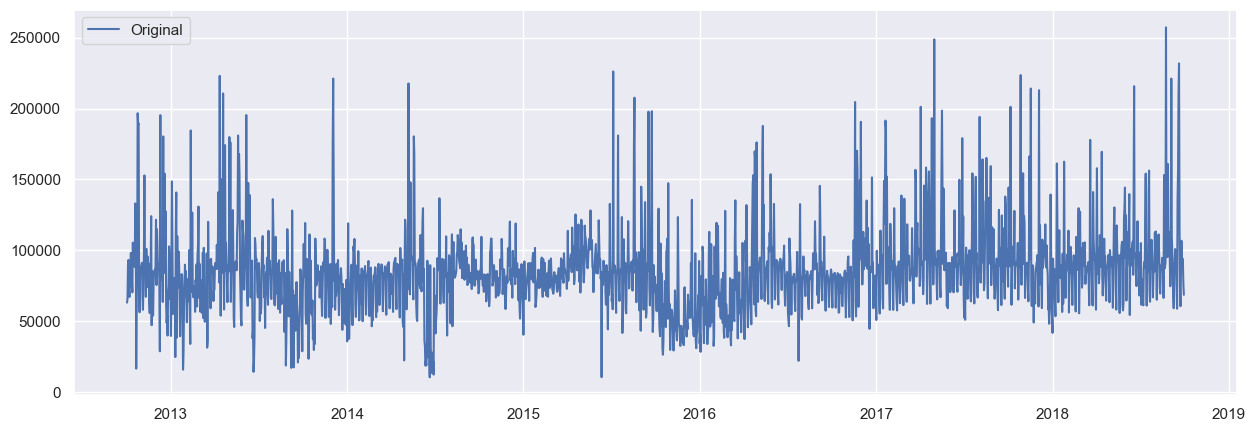

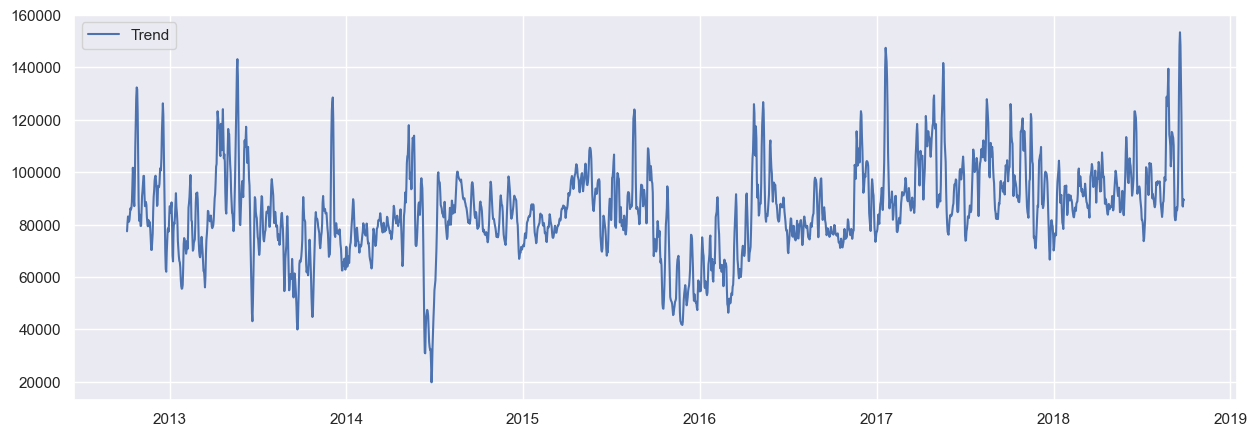

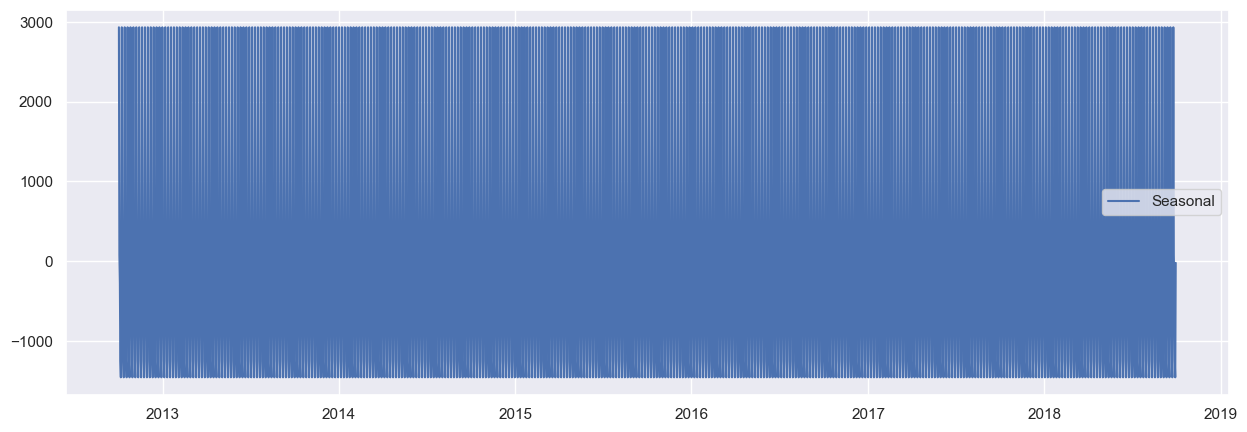

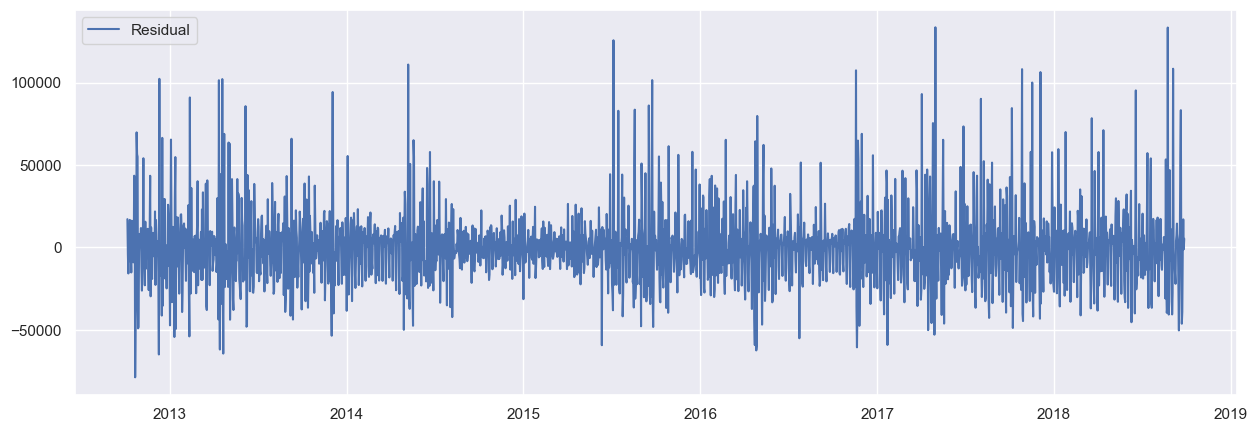

In [59]:
# Plotting original series against decomposition components
plt.figure(figsize=(15,5))
plt.plot(df_daily['traffic_volume'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

# Rolling Mean and Standard Deviation

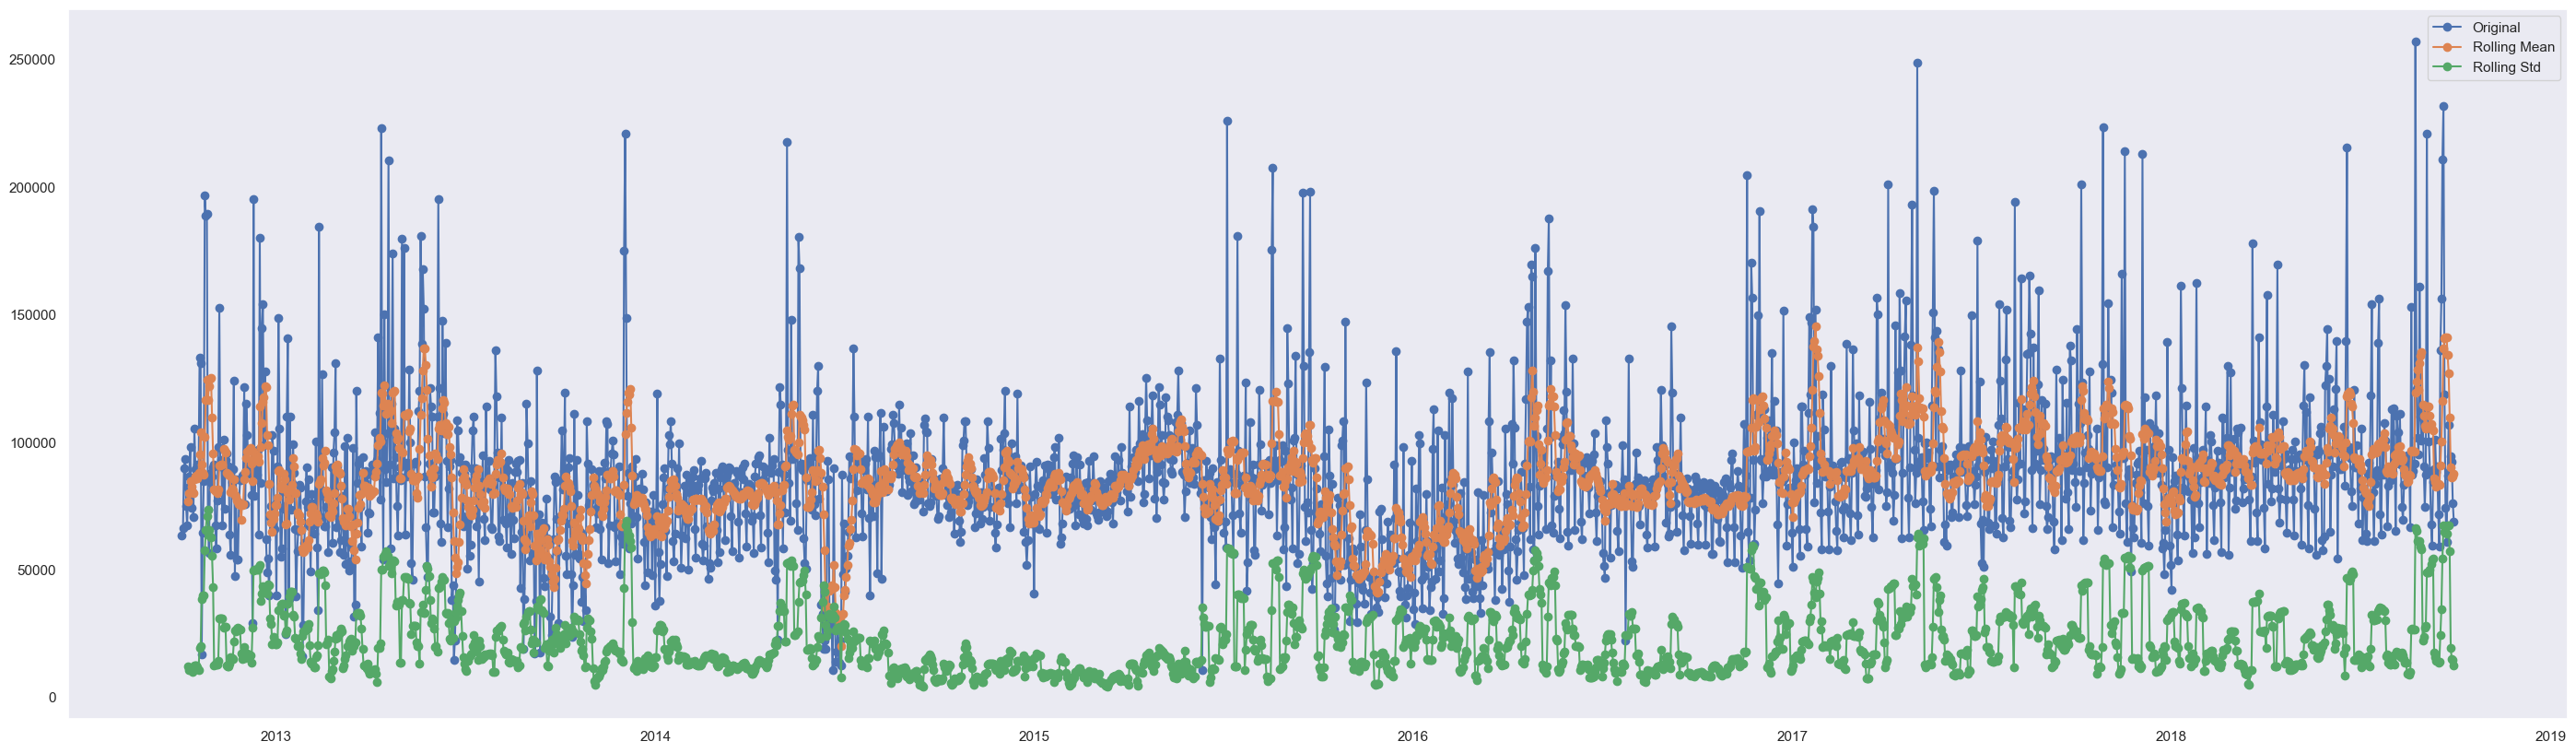

In [60]:
# Visualizing weekly rolling mean and standard deviation for traffic volume values
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df_daily['traffic_volume'], marker='o', label='Original')
plt.plot(df_daily['traffic_volume'].rolling(window=7).mean(), marker='o', label='Rolling Mean')
plt.plot(df_daily['traffic_volume'].rolling(window=7).std(), marker='o', label='Rolling Std')
plt.legend()
plt.show()

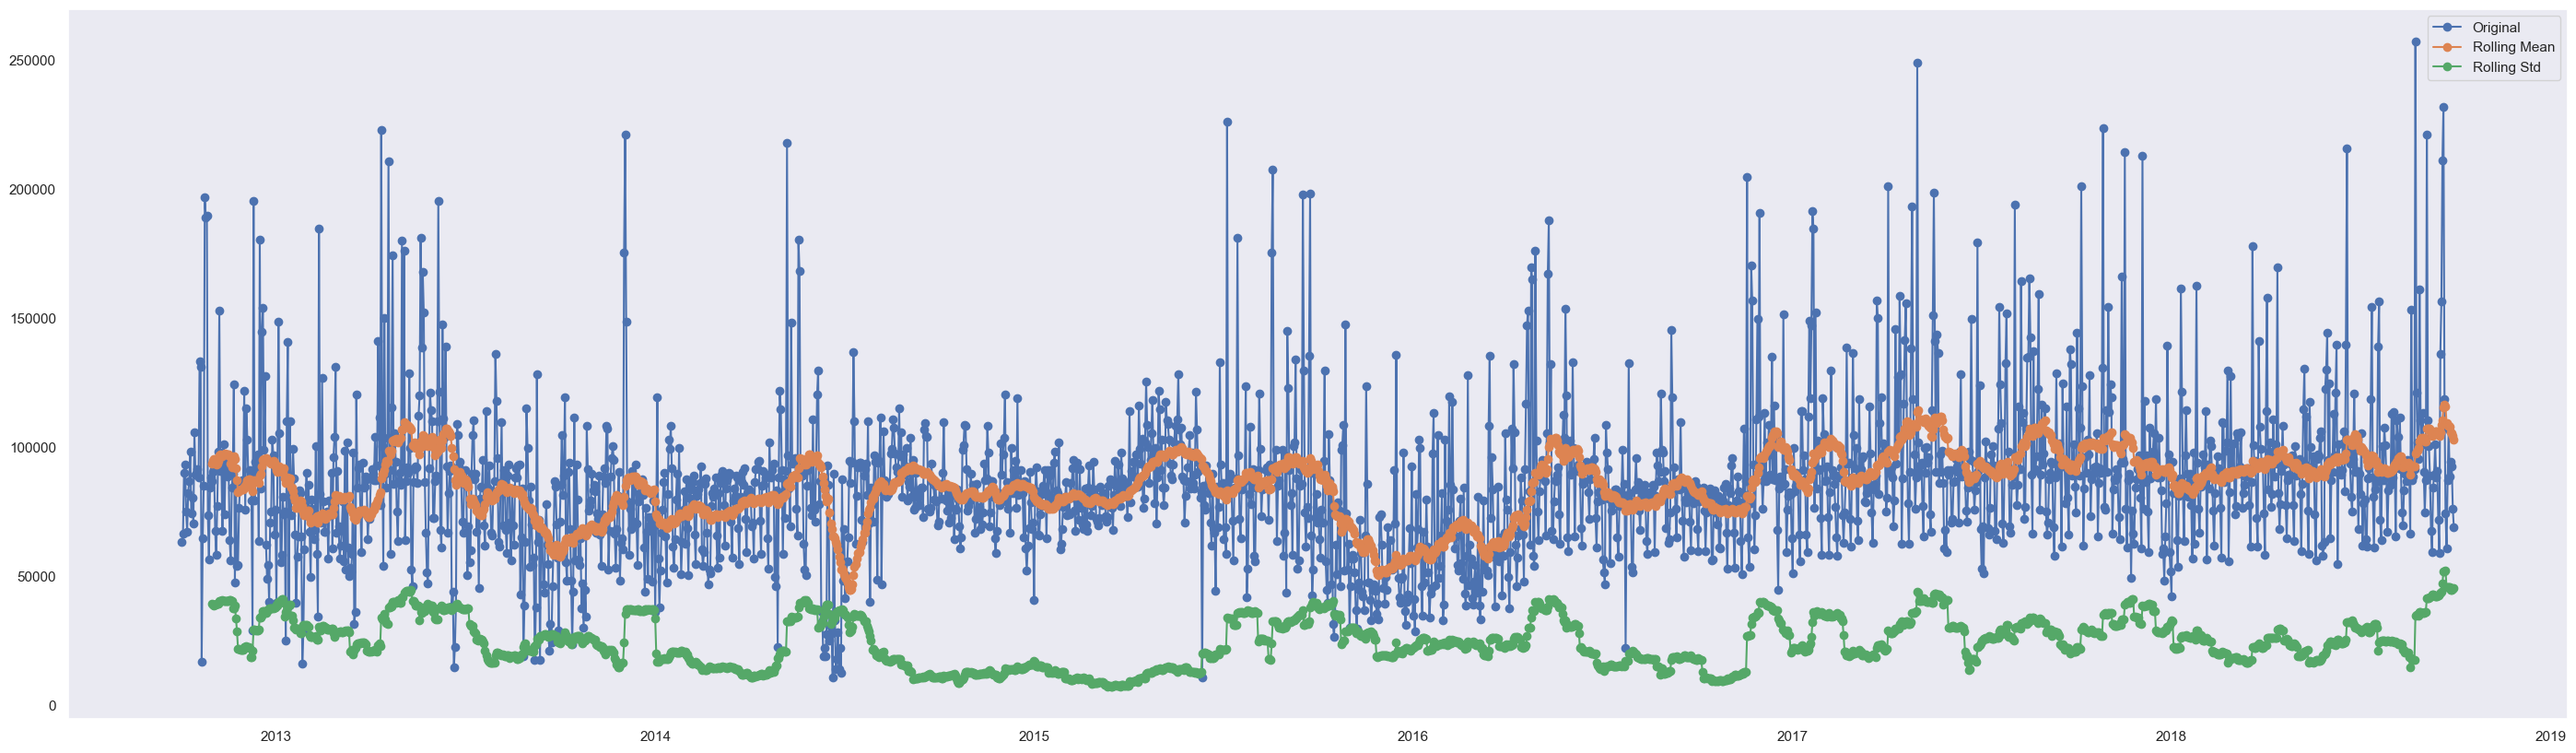

In [61]:
# Visualizing monthly rolling mean and standard deviation for traffic volume values
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df_daily['traffic_volume'], marker='o', label='Original')
plt.plot(df_daily['traffic_volume'].rolling(window=30).mean(), marker='o', label='Rolling Mean')
plt.plot(df_daily['traffic_volume'].rolling(window=30).std(), marker='o', label='Rolling Std')
plt.legend()
plt.show()

The weekly rolling mean and standard deviation are a bit too crowded to make a visual determination. Although there are ups and downs both the monthly rolling mean and standard deviation remain relatively constant over the entirety of our traffic volume values. To confirm that our eyes aren't deceiving us, we'll define a function to check the stationarity of each numerical component of our dataset using the Augmented Dickey-Fuller test. The code for the function was adapated from Kaggle user [Leonie](https://www.kaggle.com/iamleonie).

# Stationarity Check

In [62]:
# Defining function to check stationarity and return results
def check_stationarity(series, signif=0.05, name='', verbose=False):
    

    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [63]:
# ADF Test on each column
for name, column in df_daily[['temp', 'rain_in', 'snow_in', 'pct_cloud_cover', 'traffic_volume']].iteritems():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "temp" 
    -----------------------------------------------
ADF Statistic: -3.045538
p-value: 0.030855
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "rain_in" 
    -----------------------------------------------
ADF Statistic: -6.898263
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "snow_in" 
    -----------------------------------------------
ADF Statistic: -9.547817
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "pct_cloud_cover" 
    -----------------------------------------------
ADF Statistic: -8.954713
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "traffic_volume" 
    -----------------------------------------------
ADF Statistic: -5.566721
p-value: 0.000001
Critical V

Good news! Each numerical component in our dataset is stationary. For time series models like ARMA or ARIMA, it's important to confirm that the data is stationary and take any necessary measures to make it so before modeling. The last thing we'll check before modeling is the importance of each input variable.

# Feature Importances

In [64]:
# Reading in df_daily dataframe for modeling purposes
df_daily = pd.read_csv('data/complete_daily_values.csv', index_col=0)
df_daily.reset_index(inplace=True)
df_daily['date'] = pd.to_datetime(df_daily['date'], infer_datetime_format=True)

In [65]:
# Defining new dataframe with numerical features to be used in modeling
df_prophet = df_daily[['date', 'temp', 'rain_in', 'snow_in', 'pct_cloud_cover', 'traffic_volume']]
df_prophet.columns = ['ds', 'temp', 'rain_in', 'snow_in', 'pct_cloud_cover', 'y']
df_prophet

ds       temp  rain_in  snow_in  pct_cloud_cover      y
0    2012-10-02  63.056000      0.0      0.0        29.133333  63289
1    2012-10-03  55.874300      0.0      0.0         3.850000  66345
2    2012-10-04  61.173500      0.0      0.0        16.708333  89939
3    2012-10-05  48.070727      0.0      0.0        75.000000  93336
4    2012-10-06  40.272957      0.0      0.0        61.652174  74910
...         ...        ...      ...      ...              ...    ...
2185 2018-09-26  51.522500      0.0      0.0        39.833333  88627
2186 2018-09-27  55.613120      0.0      0.0        61.200000  94434
2187 2018-09-28  47.189000      0.0      0.0        26.250000  92518
2188 2018-09-29  40.973360      0.0      0.0        57.360000  76242
2189 2018-09-30  47.940385      0.0      0.0        85.384615  68785

[2190 rows x 6 columns]

In [66]:
# Defining X and y for train/test splits
X = df_prophet.drop(columns=['ds', 'y'])
y = df_prophet['y']

seedNum = 888
cpu_num = 6

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seedNum)

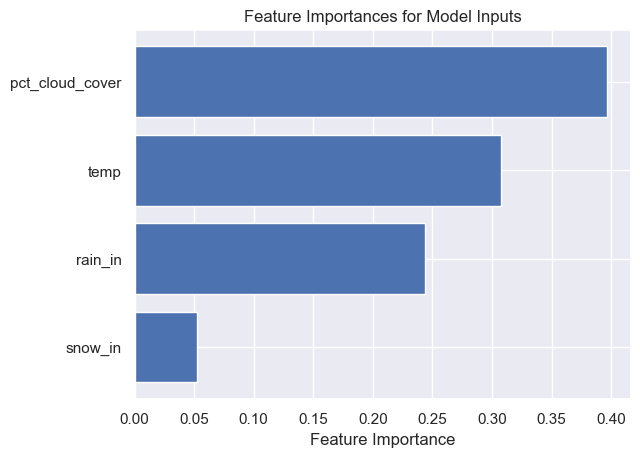

In [67]:
# Instantiating Randome Forest model to determine feature importances
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(X, y)

# Calculating and plotting feature importances
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-5:] #Top features
plt.title('Feature Importances for Model Inputs')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

Feature importance is a measure of how important each feature is in the prediction of our target variable and quantifies how much the performance of the model worsens if the feature were to be removed. Percent cloud cover is our most important feature, followed by temperature and rain. Snow doesn't appear to be a very important feature but we'll keep it in our models.

# Prophet Modeling

Prophet is open-source software that was developed by Facebook's Core Data Science team. It can be used for forecasting time series data and can be fit with yearly, weekly, and daily seasonalities, plus holiday effects. Due to the presence of holidays and the potential for seasonality in our data, we'll proceed with using Prophet and start with a baseline model. More information about Prophet can be found on its [Github page](https://facebook.github.io/prophet/).

In [68]:
# Define train and test sets
prophet_train_size = int(len(df_prophet) * 0.8)

prophet_train = df_prophet[:prophet_train_size]
prophet_test = df_prophet[prophet_train_size:]

In [69]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', prophet_train['ds'].min())
print('The end time of the training dataset is ', prophet_train['ds'].max())
print('The start time of the testing dataset is ', prophet_test['ds'].min())
print('The end time of the testing dataset is ', prophet_test['ds'].max())

The start time of the training dataset is  2012-10-02 00:00:00
The end time of the training dataset is  2017-07-19 00:00:00
The start time of the testing dataset is  2017-07-20 00:00:00
The end time of the testing dataset is  2018-09-30 00:00:00


In [70]:
# Use the default hyperparameters to initiate the baseline Prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(prophet_train)

15:47:19 - cmdstanpy - INFO - Chain [1] start processing
15:47:19 - cmdstanpy - INFO - Chain [1] done processing


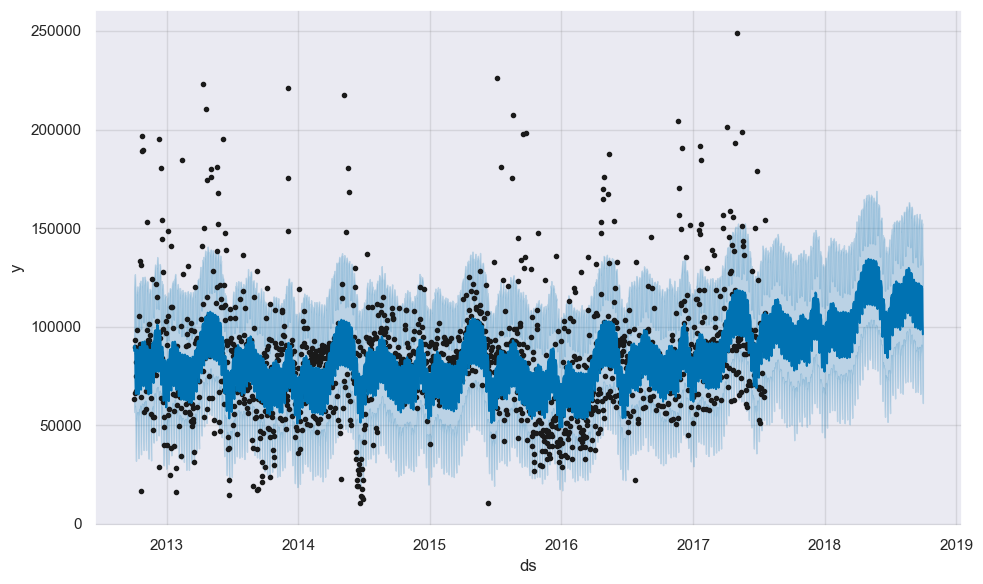

In [71]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(prophet_test))

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

# Visualize the forecast
model_baseline.plot(forecast_baseline);

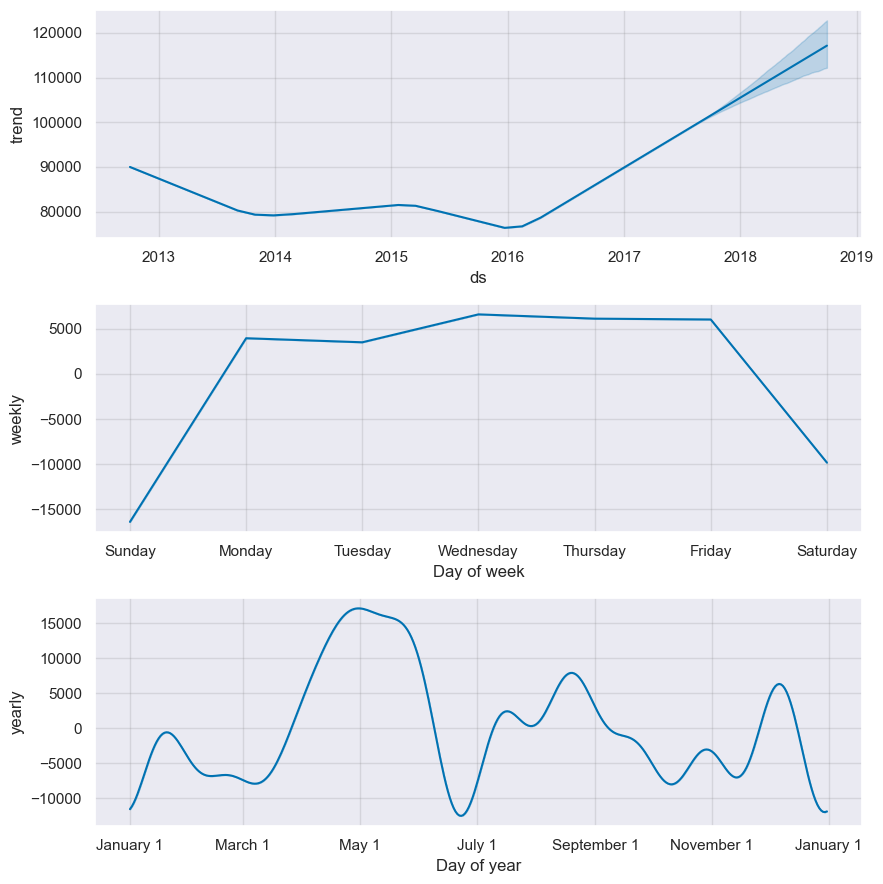

In [72]:
# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

In [73]:
# Merge actual and predicted values
performance_baseline = pd.merge(prophet_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-len(prophet_test):], on='ds')

# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

# Check RMSE value
performance_baseline_RMSE = mean_squared_error(performance_baseline['y'], performance_baseline['yhat'])**0.5
print(f'The RMSE for the baseline model is {performance_baseline_RMSE}')

The MAE for the baseline model is 24863.537437050258
The MAPE for the baseline model is 0.27531903185245854
The RMSE for the baseline model is 30798.190873665575


# Multivariate Prophet Model

After running the baseline model we can add the additional regressors to try and refine our model.

In [74]:
# Instantiating model with custom weekly seasonality based on weekly trend observed from baseline model
model_multivariate = Prophet(daily_seasonality=False,
                             weekly_seasonality=False,
                             yearly_seasonality=False,
                             ).add_seasonality(
                                name='weekly',
                                period=7,
                                fourier_order=20)

# Adding regressors
model_multivariate.add_regressor('rain_in', standardize=False)
model_multivariate.add_regressor('snow_in', standardize=False)
model_multivariate.add_regressor('temp', standardize=False)
model_multivariate.add_regressor('pct_cloud_cover', standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(prophet_train)

15:47:21 - cmdstanpy - INFO - Chain [1] start processing
15:47:23 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=len(prophet_test))

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, df_prophet[['ds', 'rain_in', 'snow_in', 'temp', 'pct_cloud_cover']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

ds  rain_in  snow_in       temp  pct_cloud_cover
2180 2018-09-21     0.01      0.0  54.840875        72.906250
2181 2018-09-22     0.00      0.0  53.161250        19.291667
2182 2018-09-23     0.00      0.0  62.186000        27.708333
2183 2018-09-24     0.27      0.0  64.351143        53.214286
2184 2018-09-25     0.10      0.0  52.898000        81.161290
2185 2018-09-26     0.00      0.0  51.522500        39.833333
2186 2018-09-27     0.00      0.0  55.613120        61.200000
2187 2018-09-28     0.00      0.0  47.189000        26.250000
2188 2018-09-29     0.00      0.0  40.973360        57.360000
2189 2018-09-30     0.00      0.0  47.940385        85.384615

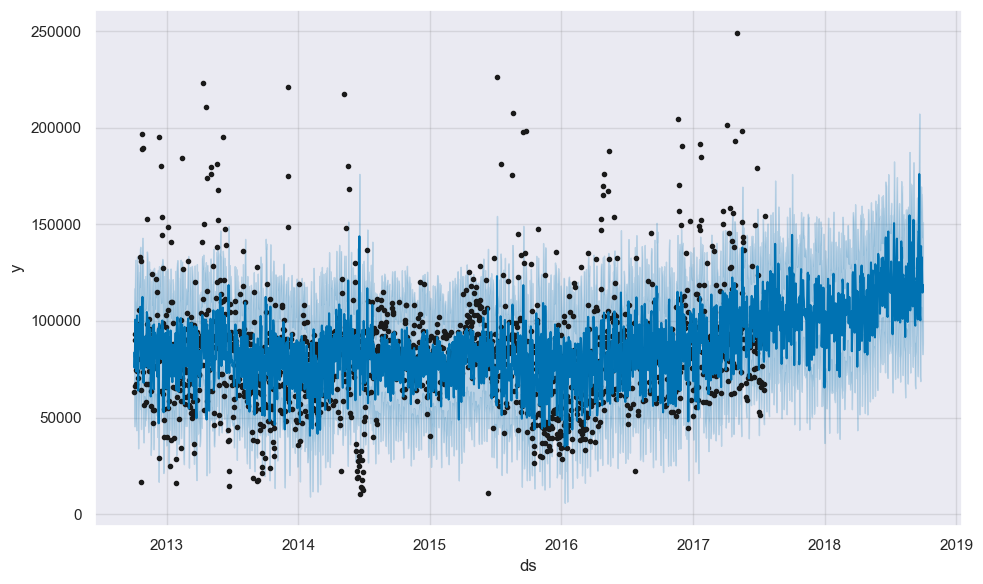

In [76]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate);

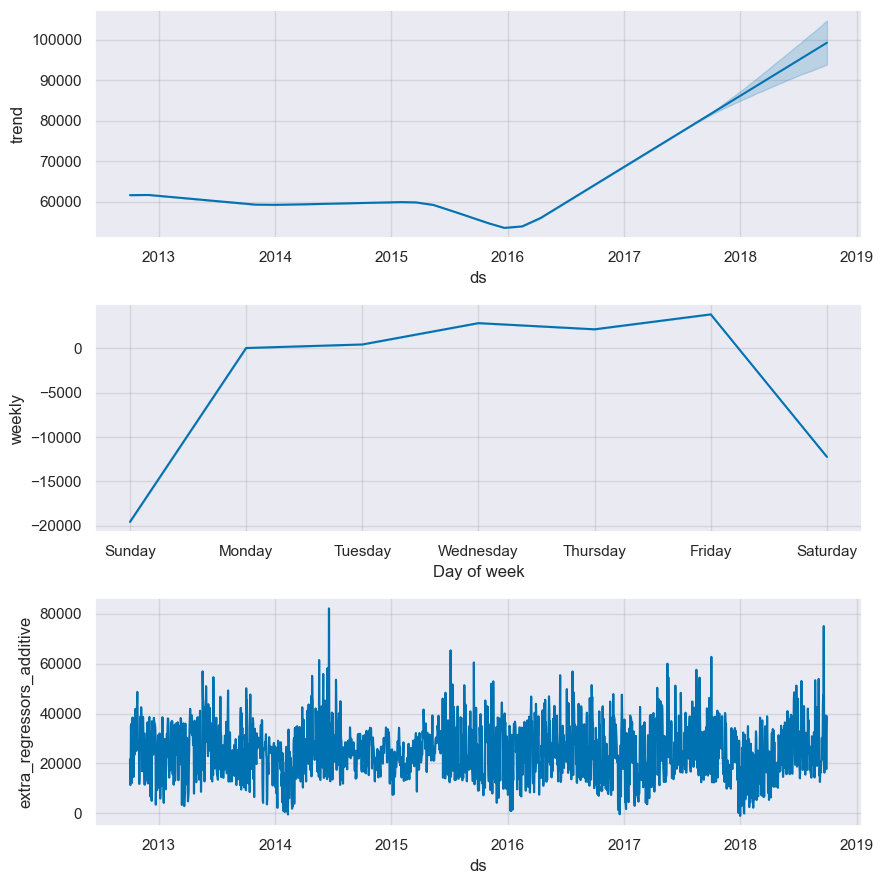

In [77]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [78]:
# Merge actual and predicted values
performance_multivariate = pd.merge(prophet_test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-len(prophet_test):], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

# Check RMSE value
performance_multivariate_RMSE = mean_squared_error(performance_multivariate['y'], performance_multivariate['yhat'])**0.5
print(f'The RMSE for the multivariate model is {performance_multivariate_RMSE}')

The MAE for the multivariate model is 22353.14037730364
The MAPE for the multivariate model is 0.2535249130026174
The RMSE for the multivariate model is 26802.404974119952


We've made an improvement on our baseline in every metric. We can check the coefficients of the input variables to determine the increase in traffic volume with a one-unit increase in the input variable.

In [79]:
regressor_coefficients(model_multivariate)

regressor regressor_mode  center   coef_lower         coef  \
0          rain_in       additive     0.0  9795.325257  9795.325257   
1          snow_in       additive     0.0 -3043.547135 -3043.547135   
2             temp       additive     0.0   178.568462   178.568462   
3  pct_cloud_cover       additive     0.0   355.493807   355.493807   

    coef_upper  
0  9795.325257  
1 -3043.547135  
2   178.568462  
3   355.493807

# Multivariate Prophet Model with Holidays

Now that we have a model that includes multiple additional regressors, we'll incorporate the holiday data by using Python's built-in holiday function and adding the Minnesota State Fair. "The Great Minnesota Get-Together" is the biggest state fair in the country in terms of daily attendance and second in total attendance. Only the Texas State Fair has more total visitors but it tends to run for twice as long as Minnesota's.

In [80]:
import holidays

# Listing each year in dataset as well as forecast years (2019-2020)
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

# Looping through each year in our dataset to create a dataframe of holidays
holiday_list = []
for holiday in holidays.US(years=years).items():
    holiday_list.append(holiday)

df_holidays = pd.DataFrame(holiday_list, columns=['ds', 'holiday'])

# Converting to datetime value
df_holidays['ds'] = pd.to_datetime(df_holidays['ds'], infer_datetime_format=True)

# Adding Minnesota State Fair to holiday dataframe
fair_dates = ['2013-08-22', '2014-08-21', '2015-08-27', '2016-08-25', '2017-08-24', '2018-08-23', '2019-08-22']
fair = pd.DataFrame({'holiday': "State Fair", 'ds' : pd.to_datetime(fair_dates)})  
df_holidays = pd.concat([df_holidays, fair])

In [81]:
# Instantiating model with custom weekly seasonality and holiday data
model_holidays = Prophet(holidays=df_holidays,
                         daily_seasonality=False,
                         weekly_seasonality=False,
                         yearly_seasonality=False,
                         ).add_seasonality(
                         name='weekly',
                         period=7,
                         fourier_order=20)

# Add regressor
model_holidays.add_regressor('rain_in', standardize=False)
model_holidays.add_regressor('snow_in', standardize=False)
model_holidays.add_regressor('temp', standardize=False)
model_holidays.add_regressor('pct_cloud_cover', standardize=False)

model_holidays.fit(prophet_train)

15:47:26 - cmdstanpy - INFO - Chain [1] start processing
15:47:28 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
# Create the time range for the forecast
future_holidays = model_holidays.make_future_dataframe(periods=len(prophet_test))

# Append the regressor values
future_holidays = pd.merge(future_holidays, df_prophet[['ds', 'rain_in', 'snow_in', 'temp', 'pct_cloud_cover']], on='ds', how='inner')

# Fill the missing values with the previous value
future_holidays = future_holidays.fillna(method='ffill')

# Check the data
future_holidays.tail(10)


ds  rain_in  snow_in       temp  pct_cloud_cover
2180 2018-09-21     0.01      0.0  54.840875        72.906250
2181 2018-09-22     0.00      0.0  53.161250        19.291667
2182 2018-09-23     0.00      0.0  62.186000        27.708333
2183 2018-09-24     0.27      0.0  64.351143        53.214286
2184 2018-09-25     0.10      0.0  52.898000        81.161290
2185 2018-09-26     0.00      0.0  51.522500        39.833333
2186 2018-09-27     0.00      0.0  55.613120        61.200000
2187 2018-09-28     0.00      0.0  47.189000        26.250000
2188 2018-09-29     0.00      0.0  40.973360        57.360000
2189 2018-09-30     0.00      0.0  47.940385        85.384615

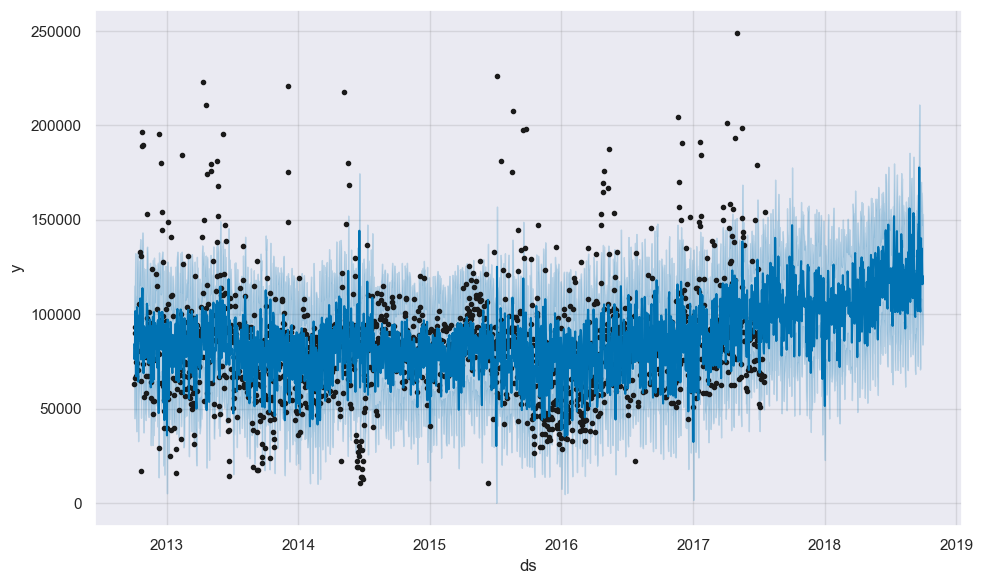

In [83]:
# Make prediction
forecast_holidays = model_holidays.predict(future_holidays)

# Visualize the forecast
model_holidays.plot(forecast_holidays); # Add semi-colon to remove the duplicated chart

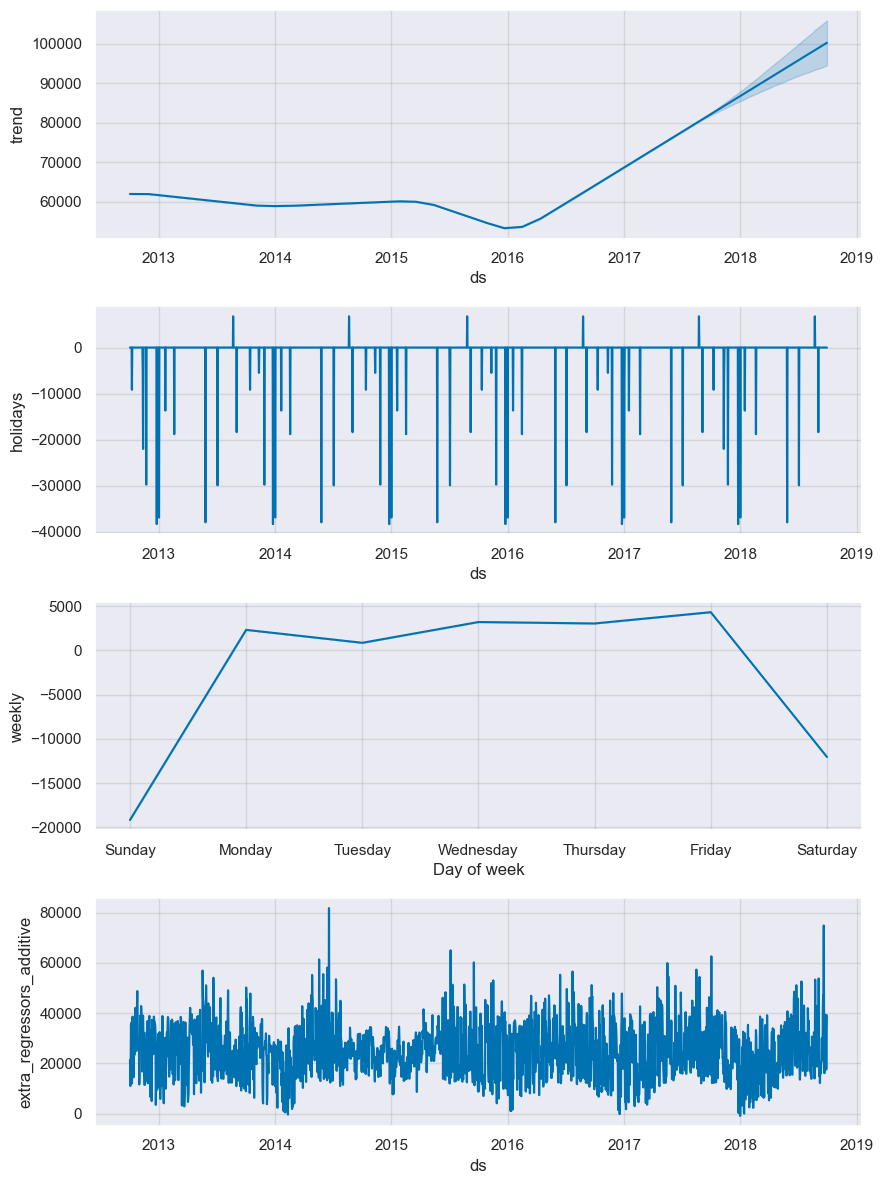

In [84]:
# Visualize the forecast components
model_holidays.plot_components(forecast_holidays);

In [85]:
# Merge actual and predicted values
performance_holidays = pd.merge(prophet_test, forecast_holidays[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-len(prophet_test):], on='ds')

# Check MAE value
performance_holidays_MAE = mean_absolute_error(performance_holidays['y'], performance_holidays['yhat'])
print(f'The MAE for the holidays model is {performance_holidays_MAE}')

# Check MAPE value
performance_holidays_MAPE = mean_absolute_percentage_error(performance_holidays['y'], performance_holidays['yhat'])
print(f'The MAPE for the holidays model is {performance_holidays_MAPE}')

# Check RMSE value
performance_holidays_RMSE = mean_squared_error(performance_holidays['y'], performance_holidays['yhat'])**0.5
print(f'The RMSE for the holidays model is {performance_holidays_RMSE}')

The MAE for the holidays model is 22756.787838997065
The MAPE for the holidays model is 0.2559026847386775
The RMSE for the holidays model is 26848.107837894044


The results after including the holidays are basically the same with not enough difference between them to justify omitting the holiday data. With the size of the Minnesota State Fair, combined with the impact other holidays have on traffic volume, I feel justified in using the multivariate model with holidays included as the final model. Once again we'll check the coefficients then visualize our predictions.

In [86]:
# Checking coefficients after incorporating holidays
regressor_coefficients(model_holidays)

regressor regressor_mode  center   coef_lower         coef  \
0          rain_in       additive     0.0  9704.712554  9704.712554   
1          snow_in       additive     0.0 -3056.630386 -3056.630386   
2             temp       additive     0.0   171.187867   171.187867   
3  pct_cloud_cover       additive     0.0   361.846397   361.846397   

    coef_upper  
0  9704.712554  
1 -3056.630386  
2   171.187867  
3   361.846397

In [87]:
# Resampling to bi-weekly values
df_prophet_weekly = df_prophet.copy()
df_prophet_weekly.set_index('ds', inplace=True)
df_prophet_weekly = df_prophet_weekly.resample('SMS').agg({'temp':'mean',
                                 'rain_in':'sum',
                                 'pct_cloud_cover':'mean',
                                 'y':'mean',})

y_pred = performance_holidays[['ds', 'yhat']]
y_pred_weekly = y_pred.copy()
y_pred_weekly.set_index('ds', inplace=True)
y_pred_weekly = y_pred_weekly.resample('SMS').mean()

In [88]:
# Define graph train and test sets
prophet_train_size = int(len(df_prophet_weekly) * 0.8)

graph_train = df_prophet_weekly[:prophet_train_size]
graph_test = df_prophet_weekly[prophet_train_size:]

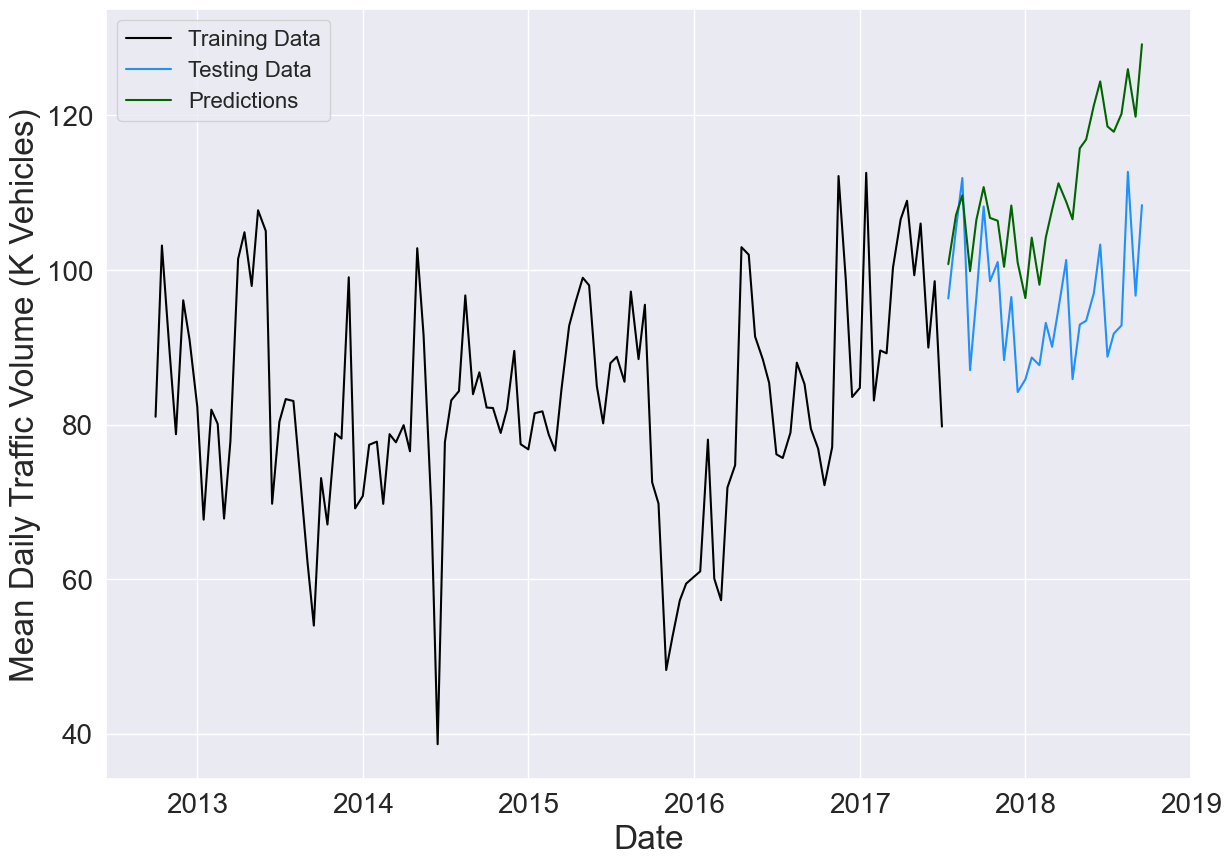

In [89]:
# Plot for multivariate model with holidays
plt.figure(figsize=(14,10))
plt.plot(graph_train['y']/1000, color = "black",label='Training Data')
plt.plot(graph_test['y']/1000, color = "dodgerblue",label='Testing Data')
plt.plot(y_pred_weekly['yhat']/1000, color='darkgreen', label = 'Predictions')
plt.ylabel('Mean Daily Traffic Volume (K Vehicles)', fontsize=24)
plt.xlabel('Date', fontsize=24)
# plt.title('Train/Test Split for Daily Traffic Volumes', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=16);

# FINAL MODEL: Multivariate, Holidays, Trained on Entire Dataset

Now that a final model has been selected, we'll re-run it using the entire dataset. In order to use additional regressors to predict future values, Prophet requires data for each of those values for any of the desired future prediction dates. We'll once again use NOAA data to fill out the temperature and precipitation data then create a univariate Prophet model to generate future *pct_cloud_cover* data.

In [90]:
# Reading in NOAA data
df_noaa_future = pd.read_csv('data/noaa_data_future.csv')
df_noaa_future = df_noaa_future[['DATE', 'PRCP', 'SNOW', 'TAVG']]

# Converting to datetime value
df_noaa_future['DATE'] = pd.to_datetime(df_noaa_future['DATE'], infer_datetime_format=True)

# Renaming columns to match df_prophet
df_noaa_future.rename(columns={'DATE':'ds',
                               'PRCP':'rain_in',
                               'SNOW':'snow_in',
                               'TAVG':'temp'}, inplace=True)

In [91]:
df_noaa_future

ds  rain_in  snow_in  temp
0    2018-10-01     0.34      0.0    48
1    2018-10-02     0.00      0.0    50
2    2018-10-03     0.61      0.0    62
3    2018-10-04     0.22      0.0    45
4    2018-10-05     0.11      0.0    46
...         ...      ...      ...   ...
1651 2023-04-09     0.00      0.0    58
1652 2023-04-10     0.00      0.0    60
1653 2023-04-11     0.00      0.0    65
1654 2023-04-12     0.00      0.0    74
1655 2023-04-13      NaN      NaN    75

[1656 rows x 4 columns]

In [92]:
# Creating pct_cloud_cover dataframe, instantiating Prophet model, and generating predictions for the next two years
df_daily = pd.read_csv('data/complete_daily_values.csv')
df_clouds = df_daily[['date', 'pct_cloud_cover']]
df_clouds.columns = ['ds', 'y']
m = Prophet()
m.fit(df_clouds)
future = m.make_future_dataframe(periods=731)
forecast = m.predict(future)
y_pred_clouds = forecast[['ds', 'yhat']]
y_pred_clouds = y_pred_clouds[-731:]

15:47:33 - cmdstanpy - INFO - Chain [1] start processing
15:47:33 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
# Merging NOAA data with pct_cloud_cover predictions
final_preds = pd.merge(y_pred_clouds, df_noaa_future, on='ds', how='inner')
final_preds.rename(columns={'yhat':'pct_cloud_cover'}, inplace=True)
final_preds

ds  pct_cloud_cover  rain_in  snow_in  temp
0   2018-10-01        39.774052     0.34      0.0    48
1   2018-10-02        38.137030     0.00      0.0    50
2   2018-10-03        38.267884     0.61      0.0    62
3   2018-10-04        39.259253     0.22      0.0    45
4   2018-10-05        35.234920     0.11      0.0    46
..         ...              ...      ...      ...   ...
726 2020-09-26        33.823431     0.01      0.0    67
727 2020-09-27        35.885231     0.03      0.0    59
728 2020-09-28        38.910726     0.02      0.0    53
729 2020-09-29        37.361880     0.00      0.0    54
730 2020-09-30        37.560481     0.05      0.0    56

[731 rows x 5 columns]

Now that we have two years of data for each of the additional regressors we can run the final model and generate our final predictions.

In [94]:
# Recreate df_prophet dataframe to ensure final model is run on the data we want
df_prophet = df_daily[['date', 'temp', 'rain_in', 'snow_in', 'pct_cloud_cover', 'traffic_volume']]
df_prophet.columns = ['ds', 'temp', 'rain_in', 'snow_in', 'pct_cloud_cover', 'y']

# Instantiate final model with holiday data and custom weekly seasonality
model_final = Prophet(holidays=df_holidays,
                         daily_seasonality=False,
                         weekly_seasonality=False,
                         yearly_seasonality=False,
                         ).add_seasonality(
                         name='weekly',
                         period=7,
                         fourier_order=20)

# Add regressor
model_final.add_regressor('rain_in', standardize=True)
model_final.add_regressor('snow_in', standardize=True)
model_final.add_regressor('temp', standardize=True)
model_final.add_regressor('pct_cloud_cover', standardize=True)

# Fit model
model_final.fit(df_prophet)

15:47:34 - cmdstanpy - INFO - Chain [1] start processing
15:47:35 - cmdstanpy - INFO - Chain [1] done processing


In [95]:
# Create the time range for the forecast
future_final = model_final.make_future_dataframe(periods=731)

# Append the regressor values
future_final = pd.merge(future_final, final_preds, on='ds', how='inner')

# Fill the missing values with the previous value
future_final = future_final.fillna(method='ffill')

# Check the data
future_final.tail(10)

ds  pct_cloud_cover  rain_in  snow_in  temp
721 2020-09-21        37.509775     0.05      0.0    67
722 2020-09-22        36.299959     0.00      0.0    69
723 2020-09-23        36.836408     0.00      0.0    71
724 2020-09-24        38.196526     0.05      0.0    70
725 2020-09-25        34.489548     0.00      0.0    68
726 2020-09-26        33.823431     0.01      0.0    67
727 2020-09-27        35.885231     0.03      0.0    59
728 2020-09-28        38.910726     0.02      0.0    53
729 2020-09-29        37.361880     0.00      0.0    54
730 2020-09-30        37.560481     0.05      0.0    56

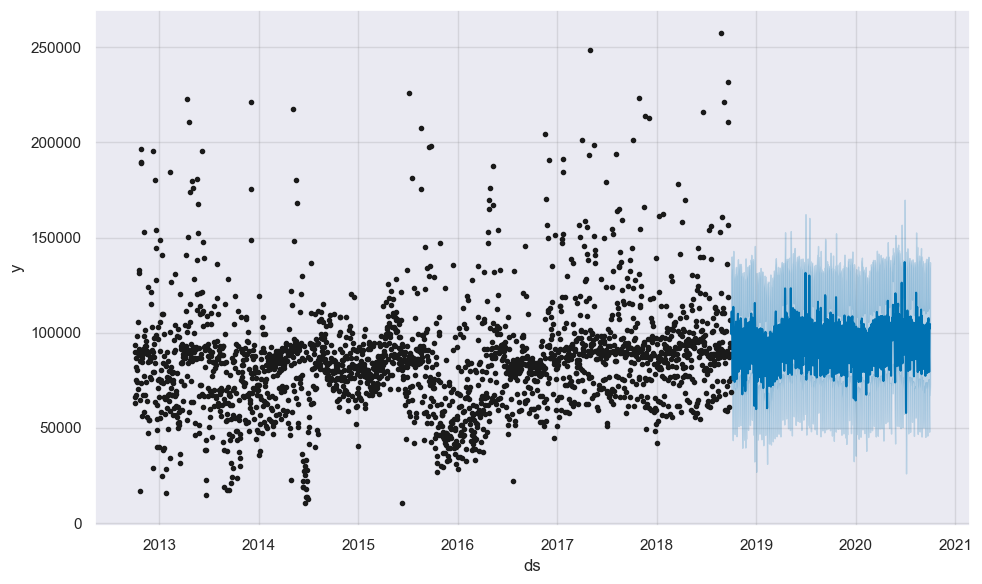

In [96]:
# Make prediction
forecast_final = model_final.predict(future_final)

# Visualize the forecast
model_final.plot(forecast_final); # Add semi-colon to remove the duplicated chart

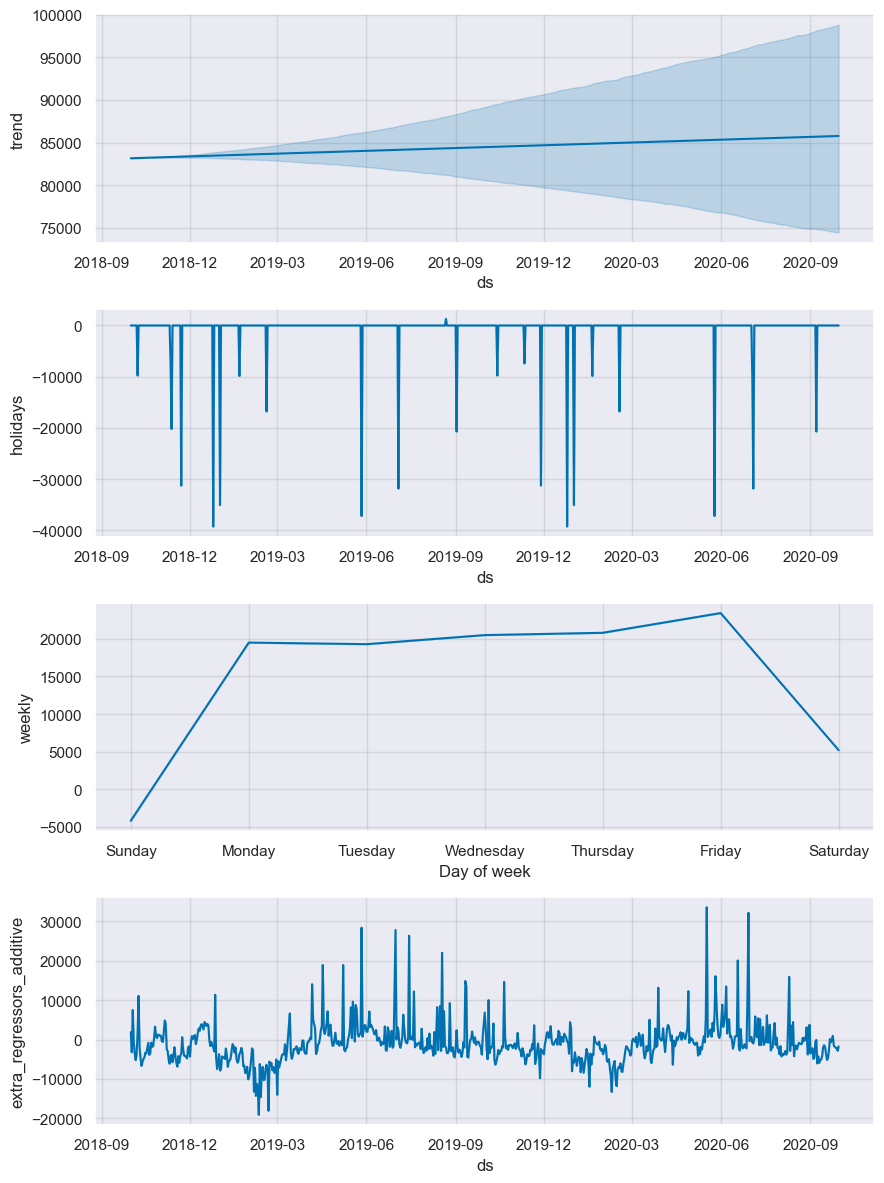

In [97]:
# Visualize the forecast components
model_final.plot_components(forecast_final);

In [98]:
# Resampling to bi-weekly values for visualizing predictions
df_prophet_weekly = df_prophet[-731:].copy()
df_prophet_weekly['ds'] = pd.to_datetime(df_prophet_weekly['ds'], infer_datetime_format=True)
df_prophet_weekly.set_index('ds', inplace=True)
df_prophet_weekly = df_prophet_weekly.resample('SMS').agg({'temp':'mean',
                                 'rain_in':'sum',
                                 'pct_cloud_cover':'mean',
                                 'y':'mean',})

y_pred = forecast_final[['ds', 'yhat']]
y_pred_weekly = y_pred.copy()
y_pred_weekly.set_index('ds', inplace=True)
y_pred_weekly = y_pred_weekly.resample('SMS').mean()

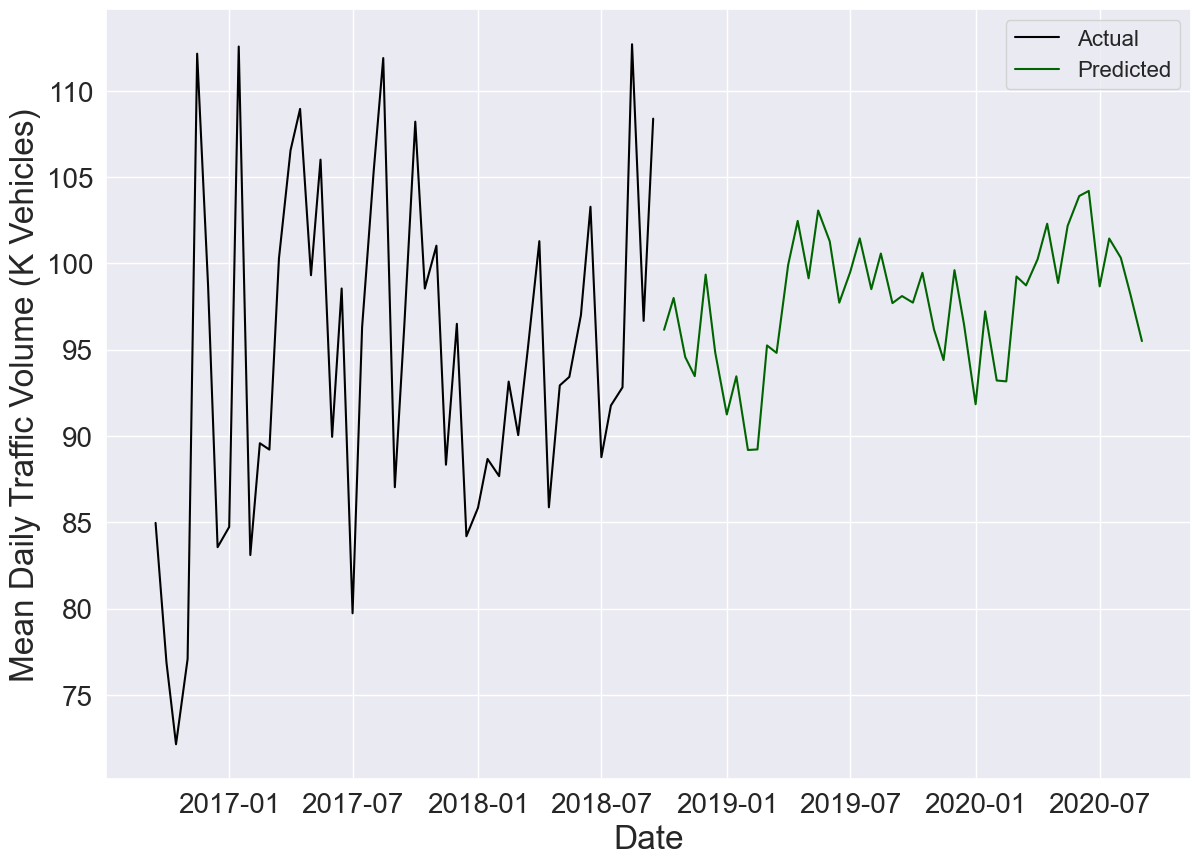

In [99]:
# Plot
plt.figure(figsize=(14, 10))
plt.plot(df_prophet_weekly['y']/1000, color='black', label='Actual')
plt.plot(y_pred_weekly['yhat'][:-1]/1000, color='darkgreen', label='Predicted')
plt.ylabel('Mean Daily Traffic Volume (K Vehicles)', fontsize=24)
plt.xlabel('Date', fontsize=24)
# plt.title('Train/Test Split for Daily Traffic Volumes', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=16);

In [100]:
# Checking final model coefficients
regressor_coefficients(model_final)

regressor regressor_mode     center    coef_lower          coef  \
0          rain_in       additive   0.094863  14130.372100  14130.372100   
1          snow_in       additive   0.144703  -2315.954343  -2315.954343   
2             temp       additive  45.903824    171.651642    171.651642   
3  pct_cloud_cover       additive  45.742471    383.862317    383.862317   

     coef_upper  
0  14130.372100  
1  -2315.954343  
2    171.651642  
3    383.862317

# Conclusion & Recommendations

Due to the fact that traffic volume tends to increase as general visiblity decreases, I recommend installing lighting systems along any stretch of I-94 that doesn't currently have it. In addition, I recommend regular inspection of reflectors, pavement markings, and signage to ensure reflectivity. Lastly, I recommend the promotion of alternate transporation options for high-volume events like the State Fair. There is a park-and-ride system in place already, but this could be incentivized through things like discounted fair tickets or food vouchers for public transit users.

# OLS Model: As-Is and Standardized

We'll run some OLS models on both unmodified data and standardized data to compare the coefficients to those returned by the Prophet model and Random Forest feature importance.

In [101]:
df_daily = pd.read_csv('data/complete_daily_values.csv', index_col=0)
df_daily.reset_index(inplace=True)
df_daily['date'] = pd.to_datetime(df_daily['date'], infer_datetime_format=True)

In [102]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Create model with all numeric variables
X = df_daily[['temp', 'rain_in', 'snow_in', 'pct_cloud_cover']]
y = df_daily['traffic_volume']

ols_model = sm.OLS(y, sm.add_constant(X)).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         traffic_volume   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     107.5
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           1.11e-83
Time:                        15:47:38   Log-Likelihood:                -25421.
No. Observations:                2190   AIC:                         5.085e+04
Df Residuals:                    2185   BIC:                         5.088e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.793e+04   1870.872     30.965      0.000    5.43e+04    6.16e+04
temp              199.9923     27.347      7.313      0.000     146.364     253.621
rain_in          1.368e+04   2105.331      6.499      0.000    9553.667    1.78e+04
snow_in         -2013.0767    791.559     -2.543      0.011   -3565.365    -460.789
pct_cloud_cover   379.8347     23.081     16.457      0.000     334.572     425.097
==============================================================================
Omnibus:                      307.113   Durbin-Watson:                   1.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1226.418
Skew:                           0.637   Prob(JB):                    4.86e-267
Kurtosis:                       6.438   Cond. No.                         268.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
ols_model.params

const              57930.888071
temp                 199.992319
rain_in            13682.326328
snow_in            -2013.076734
pct_cloud_cover      379.834726
dtype: float64

In [104]:
np.sqrt(ols_model.mse_resid)

26637.923025351025

These results are in line with those of the Prophet model.

In [105]:
# Create standardized dataframe to get all variables on the same scale
X_standardized = df_daily[['temp', 'rain_in', 'snow_in', 'pct_cloud_cover']]

for col in X_standardized:
    X_standardized[col] = (X_standardized[col] - X_standardized[col].mean()) \
                            / X_standardized[col].std()
    
X_standardized.describe()

C:\Users\pschu\AppData\Local\Temp\ipykernel_14948\1127342873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_standardized[col] = (X_standardized[col] - X_standardized[col].mean()) \


temp       rain_in       snow_in  pct_cloud_cover
count  2.190000e+03  2.190000e+03  2.190000e+03     2.190000e+03
mean   1.618689e-15 -4.822119e-16  3.698462e-16     1.744013e-15
std    1.000000e+00  1.000000e+00  1.000000e+00     1.000000e+00
min   -2.567467e+00 -3.266615e-01 -1.918977e-01    -1.723623e+00
25%   -7.328714e-01 -3.266615e-01 -1.918977e-01    -8.487166e-01
50%    1.034590e-01 -3.266615e-01 -1.918977e-01     9.703937e-03
75%    9.044985e-01 -2.233563e-01 -1.918977e-01     7.782017e-01
max    1.806662e+00  1.389502e+01  1.625232e+01     1.776190e+00

In [106]:
# Create standardized model
X = X_standardized
y = df_daily['traffic_volume']

ols_model_std = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()

ols_model_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         traffic_volume   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     107.5
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           1.11e-83
Time:                        15:47:39   Log-Likelihood:                -25421.
No. Observations:                2190   AIC:                         5.085e+04
Df Residuals:                    2185   BIC:                         5.088e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            8.549e+04    569.218    150.193      0.000    8.44e+04    8.66e+04
temp             4468.4212    611.011      7.313      0.000    3270.197    5666.645
rain_in          3973.3692    611.391      6.499      0.000    2774.400    5172.338
snow_in         -1517.9892    596.887     -2.543      0.011   -2688.514    -347.464
pct_cloud_cover  1.008e+04    612.529     16.457      0.000    8879.068    1.13e+04
==============================================================================
Omnibus:                      307.113   Durbin-Watson:                   1.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1226.418
Skew:                           0.637   Prob(JB):                    4.86e-267
Kurtosis:                       6.438   Cond. No.                         1.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
ols_model_std.params

const              85492.527397
temp                4468.421196
rain_in             3973.369204
snow_in            -1517.989157
pct_cloud_cover    10080.268985
dtype: float64

The standardized OLS model confirms that *pct_cloud_cover* is the most important feature.

In [108]:
np.sqrt(ols_model_std.mse_resid)

26637.923025351025

# Additional Visualization

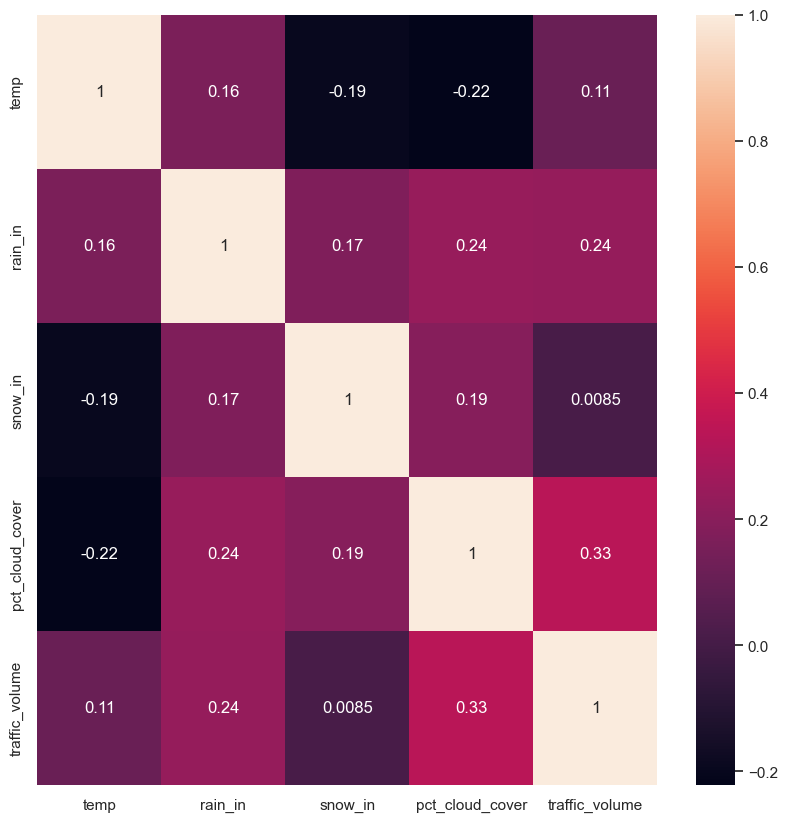

In [109]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_daily.drop(['year', 'month', 'day'], axis=1).corr(),annot=True)
plt.show()

As expected, *pct_cloud_cover* is the feature most correlated with *traffic_volume*.

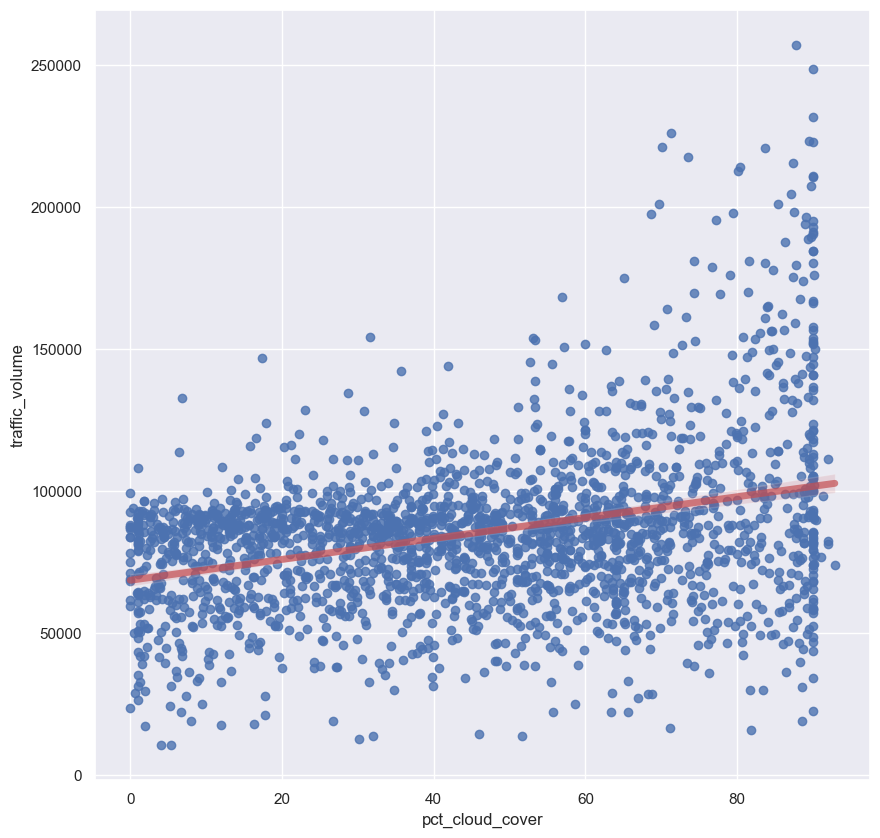

In [110]:
# Scatter plot of cloud cover against traffic volume
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(x=df_daily['pct_cloud_cover'], y=df_daily['traffic_volume'], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

In [111]:
# Grouping traffic volume by holiday
graph = df_daily.groupby(['holiday']).agg({'traffic_volume':'mean'}).sort_values(by='traffic_volume', ascending=False)
graph

traffic_volume
holiday                                   
State Fair                    92007.000000
None                          86042.551789
Veteran's Day                 78644.166667
Martin Luther King Jr. Day    78483.666667
Washington's Birthday         77649.333333
Columbus Day                  76959.833333
Labor Day                     70674.166667
Memorial Day                  61129.166667
Thanksgiving Day              60607.666667
Independence Day              54118.833333
New Year's Day                48799.500000
Christmas Day                 46635.833333

In [112]:
df_daily['traffic_volume'].mean(), graph['traffic_volume'].mean()

(85492.52739726027, 69312.64320464533)

In [113]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=90)

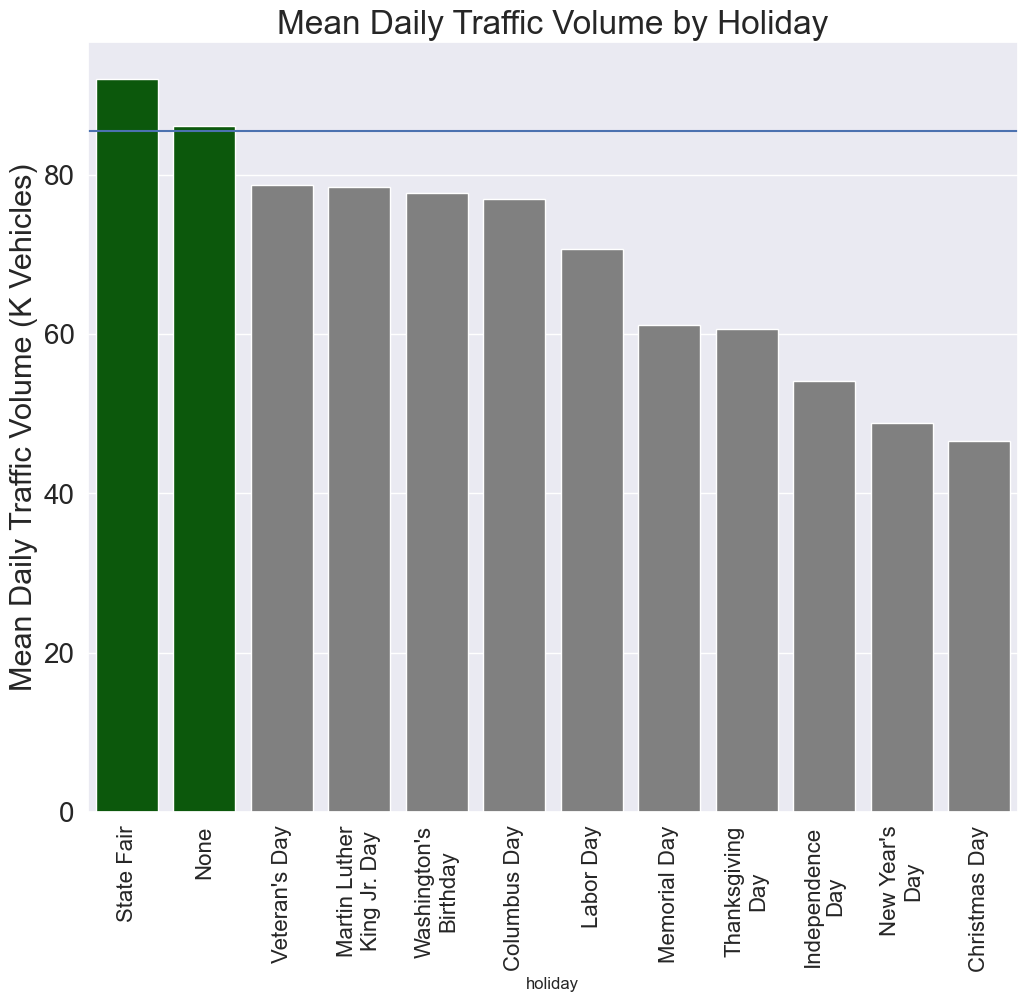

In [114]:
# Plotting mean traffic volume by holiday
fig, ax = plt.subplots(figsize = (12 , 10))
y = graph['traffic_volume'] / 1000
cols = ['darkgreen' if x > df_daily['traffic_volume'].mean() else 'gray' for x in graph['traffic_volume']]

fig = sns.barplot(data = graph,
                  x = graph.index,
                  y = y,
                  palette=cols)

fig.axhline(df_daily['traffic_volume'].mean()/1000)
# plt.xlabel('Percent Cloud Cover', size=22)
plt.xticks(size=16)
wrap_labels(ax, 13)
plt.ylabel('Mean Daily Traffic Volume (K Vehicles)', size=22)
plt.yticks(size=20)
plt.title('Mean Daily Traffic Volume by Holiday', size=24)
plt.show(fig);

In [115]:
# Grouping traffic volume by weekday
graph2 = df_daily.groupby(['weekday']).agg({'traffic_volume':'mean'})
graph2

traffic_volume
weekday                  
Friday       93138.984026
Monday       89235.083333
Saturday     75266.514377
Sunday       66705.613419
Thursday     91977.817891
Tuesday      90299.201278
Wednesday    91836.434505

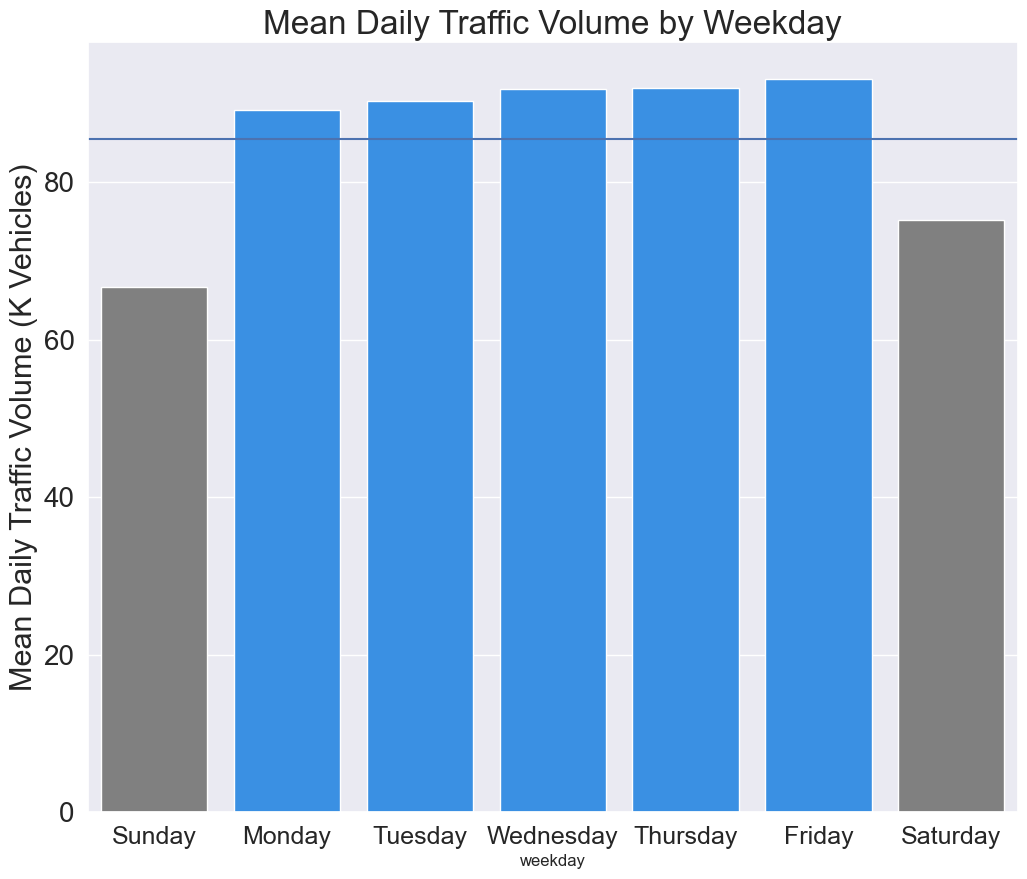

In [116]:
fig, ax = plt.subplots(figsize = (12 , 10))
y = graph2['traffic_volume'] / 1000
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
cols = ['gray', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'gray']

fig = sns.barplot(data = graph2,
                  x = graph2.index,
                  y = y,
                  palette=cols,
                  order=order)

fig.axhline(df_daily['traffic_volume'].mean()/1000)
# plt.xlabel('Percent Cloud Cover', size=22)
plt.xticks(size=18)
plt.ylabel('Mean Daily Traffic Volume (K Vehicles)', size=22)
plt.yticks(size=20)
plt.title('Mean Daily Traffic Volume by Weekday', size=24)
plt.show(fig);

In [117]:
# Creating new dataframe to group data by cloud cover
cloud_mean = df_daily.groupby('pct_cloud_cover').mean()
cloud_mean.reset_index(drop=False, inplace=True)

In [118]:
# Binning cloud cover values
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80',  '81-90',  '91-100']
cloud_mean['bin'] = pd.cut(x = cloud_mean['pct_cloud_cover'], bins = bins, labels = labels, include_lowest = True)

cloud_mean_bin = cloud_mean.groupby('bin').mean()
cloud_mean_bin.reset_index(drop=False, inplace=True)
cloud_mean_bin

bin  pct_cloud_cover       temp   rain_in   snow_in  traffic_volume  \
0    0-10         5.258038  49.247130  0.007594  0.005521    72271.308563   
1   11-20        14.979545  52.753193  0.030999  0.000552    77776.122928   
2   21-30        25.340437  52.506044  0.034489  0.004894    79481.314506   
3   31-40        35.319636  50.476209  0.054756  0.006823    79196.298320   
4   41-50        45.232113  47.245818  0.054414  0.092770    81415.823741   
5   51-60        55.168780  47.419085  0.129986  0.116342    84066.949668   
6   61-70        64.944801  39.572680  0.116995  0.246342    86958.695030   
7   71-80        74.656731  42.631204  0.166677  0.207312    97751.770968   
8   81-90        85.222739  40.484240  0.273991  0.443334   108351.284603   
9  91-100        90.724849  32.686738  0.254444  1.491667    98643.388889   

          year     month        day  
0  2015.532566  6.497214  15.212296  
1  2015.464088  6.911142  15.087477  
2  2015.714051  6.509200  15.523898  
3  2015.662771  6.109584  16.020162  
4  2015.609661  6.444290  14.963925  
5  2015.454102  6.349824  15.609147  
6  2015.022460  6.608581  16.370733  
7  2015.039785  6.606452  15.770968  
8  2015.346782  6.396167  17.273456  
9  2014.222222  4.305556  20.250000

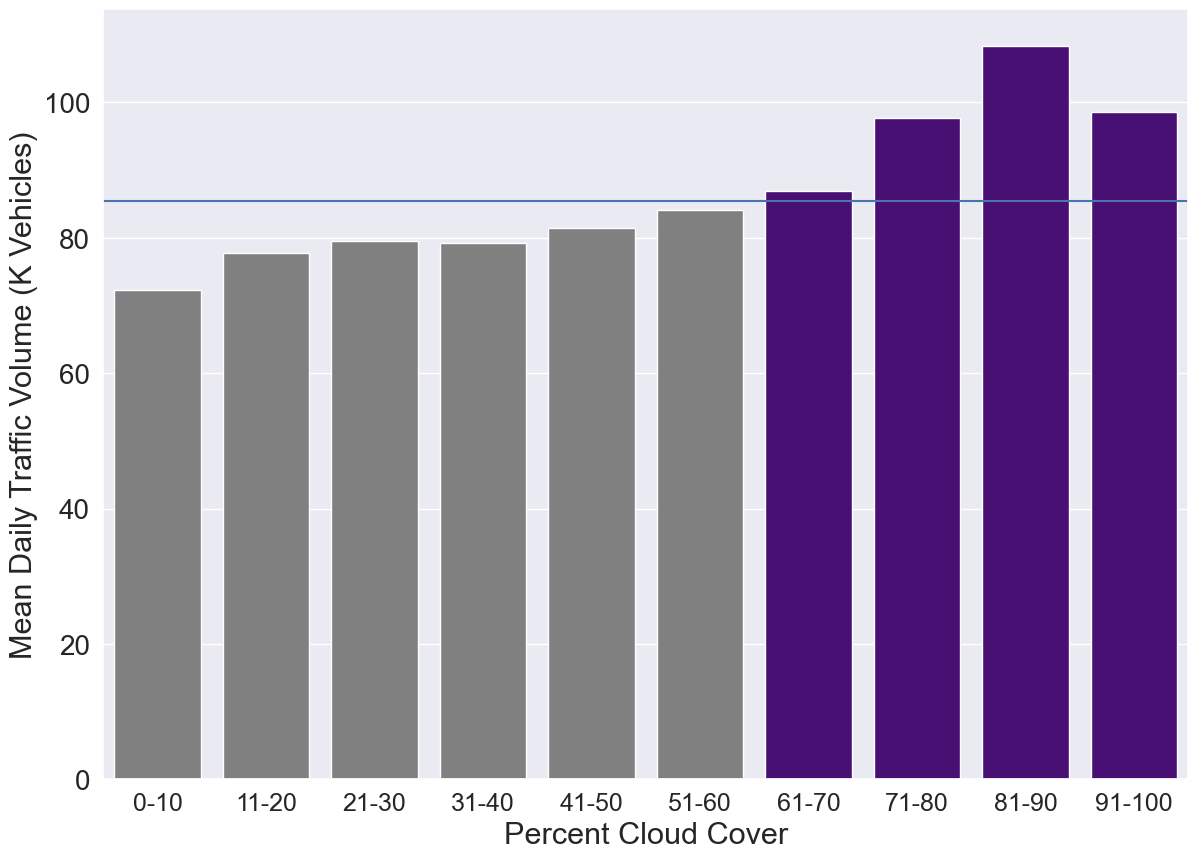

In [119]:
fig, ax = plt.subplots(figsize = (14 , 10))

y = cloud_mean_bin['traffic_volume'] / 1000
cols = ['indigo' if x > df_daily['traffic_volume'].mean() else 'gray' for x in cloud_mean_bin['traffic_volume']]

fig = sns.barplot(data = cloud_mean_bin,
                  x = 'bin',
                  y = y,
                  palette=cols)

fig.axhline(df_daily['traffic_volume'].mean() / 1000)

plt.xlabel('Percent Cloud Cover', size=22)
plt.xticks(size=18)
plt.ylabel('Mean Daily Traffic Volume (K Vehicles)', size=22)
plt.yticks(size=20)
# plt.title('Mean Traffic Volume by Percent Cloud Cover', size=24)
plt.show(fig);